In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import itertools
import time
import timeit

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

from IPython.display import Image
from IPython.core.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
def draw_heatmap(df):
    sns.set(style='white')
    corr=df.corr()
    mask=np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11,9))
    cmap=sns.diverging_palette(220,10, as_cmap=True)
    return sns.heatmap(corr,mask=mask,
                       cmap=cmap,center=0,
                       annot=True, annot_kws={'size': 10}, 
                       square=True,linewidths=0.5,
                       cbar_kws={'shrink': .5});

In [3]:
def plot_cm(y_true, y_pred, cmap = plt.cm.summer, title=None):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    plt.imshow(cnf_matrix, cmap=cmap)
    plt.title('Confusion Matrix for {}'.format(title))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cnf_matrix.max()
    for i,j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j,i, cnf_matrix[i,j],
                horizontalalignment='center',
                color='white' if cnf_matrix[i,j] > thresh else 'black')
    plt.colorbar()

In [4]:
def draw_dt(decision_tree, feat_df):
    dot_data = StringIO()
    export_graphviz(decision_tree, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feat_df.columns)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

In [5]:
def gridsearch(clf, clf_grid, X, y, cv=3, name=None):
    start = time.time()
    clf_grid_search = GridSearchCV(clf, clf_grid, cv=cv)
    clf_grid_search.fit(X, y)
    mts = clf_grid_search.cv_results_['mean_train_score']
    end = time.time()
    clf_training_score = np.mean(mts)
    clf_testing_score = clf_grid_search.score(X, y)
    print('Mean Training Score: {:.4}'.format(clf_training_score * 100))
    print('Mean Testing Score: {:.4}'.format(clf_testing_score * 100))
    print('Best Parameter Combination Found During Grid Search:', clf_grid_search.best_params_)
    print('Total Runtime for {} GridSearch: {:.4} seconds'.format(name, end-start))

In [6]:
raw_df = pd.read_csv('nba_logreg.csv')
raw_df.head()

Name  GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  \
0   Brandon Ingram  36  27.4  7.4  2.6  7.6  34.7      0.5  2.1  25.0   
1  Andrew Harrison  35  26.9  7.2  2.0  6.7  29.6      0.7  2.8  23.5   
2   JaKarr Sampson  74  15.3  5.2  2.0  4.7  42.2      0.4  1.7  24.4   
3      Malik Sealy  58  11.6  5.7  2.3  5.5  42.6      0.1  0.5  22.6   
4      Matt Geiger  48  11.5  4.5  1.6  3.0  52.4      0.0  0.1   0.0   

      ...       FTA   FT%  OREB  DREB  REB  AST  STL  BLK  TOV  TARGET_5Yrs  
0     ...       2.3  69.9   0.7   3.4  4.1  1.9  0.4  0.4  1.3          0.0  
1     ...       3.4  76.5   0.5   2.0  2.4  3.7  1.1  0.5  1.6          0.0  
2     ...       1.3  67.0   0.5   1.7  2.2  1.0  0.5  0.3  1.0          0.0  
3     ...       1.3  68.9   1.0   0.9  1.9  0.8  0.6  0.1  1.0          1.0  
4     ...       1.9  67.4   1.0   1.5  2.5  0.3  0.3  0.4  0.8          1.0  

[5 rows x 21 columns]

In [7]:
#Data Dictionary provided by dataset publisher
Image(url='https://data.world/api/exercises/dataset/logistic-regression-exercise-1/file/raw/Screen%20Shot%202017-01-25%20at%2010.20.38%20AM.png')



# Feature Engineering

In [8]:
#True Shooting Percentage: Per Wikipedia, "a statistic that measures a player's efficiency at shooting the ball".  
#Intended to be a more comprehensive metric than any of its individual shooting components.
raw_df['TSA'] = raw_df['FGA'] + (0.44*raw_df['FTA'])
raw_df['TS%'] = raw_df['PTS']/(2*raw_df['TSA'])


#3NG metric is borrowed from a Towards Data Science blogpost using formula 3NG = 3P Made * (3 - EV) - (3P Missed * EV))
#where EV is expected number of points per possession, for which we can substitute 1.06 for NBA purposes
raw_df['3NG'] = (raw_df['3P Made'] * 1.94) - ((raw_df['3PA'] - raw_df['3P Made'])*1.06)


#TOV%: An estimate of turnovers per 100 plays (utilizes part of the TS% equation), from basketball-reference.com
raw_df['TOV%'] = (raw_df['TOV'] * 100)/(raw_df['TSA'] + raw_df['TOV'])

#We created this one to measure counting stats that change the expected flow of the game and yield an "extra" possession (H/T to Jeff Herman for helping conceptualize this)
raw_df['Poss_Added'] = raw_df['STL'] + raw_df['BLK'] + raw_df['OREB']
                                            

Sources [here](https://towardsdatascience.com/the-3-point-statistic-to-rule-them-all-12ac018a955a) and [here](https://www.basketball-reference.com/about/glossary.html)

# EDA and Data Cleaning

In [9]:
raw_df.head()

Name  GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  \
0   Brandon Ingram  36  27.4  7.4  2.6  7.6  34.7      0.5  2.1  25.0   
1  Andrew Harrison  35  26.9  7.2  2.0  6.7  29.6      0.7  2.8  23.5   
2   JaKarr Sampson  74  15.3  5.2  2.0  4.7  42.2      0.4  1.7  24.4   
3      Malik Sealy  58  11.6  5.7  2.3  5.5  42.6      0.1  0.5  22.6   
4      Matt Geiger  48  11.5  4.5  1.6  3.0  52.4      0.0  0.1   0.0   

      ...      AST  STL  BLK  TOV  TARGET_5Yrs    TSA       TS%    3NG  \
0     ...      1.9  0.4  0.4  1.3          0.0  8.612  0.429633 -0.726   
1     ...      3.7  1.1  0.5  1.6          0.0  8.196  0.439239 -0.868   
2     ...      1.0  0.5  0.3  1.0          0.0  5.272  0.493171 -0.602   
3     ...      0.8  0.6  0.1  1.0          1.0  6.072  0.469368 -0.230   
4     ...      0.3  0.3  0.4  0.8          1.0  3.836  0.586548 -0.106   

        TOV%  Poss_Added  
0  13.115416         1.5  
1  16.333197         2.1  
2  15.943878         1.3  
3  14.140271         1.7  
4  17.256255         1.7  

[5 rows x 26 columns]

- A bit of trouble already...the first two names on this list, Brandon Ingram and Andrew Harrison, have incorrect stat lines when comparing to basketball-reference.com

- Aside from the actual stats being wrong, they were also drafted in 2016, which means the target variable should be inconclusive since they haven't had the opportunity to play 5 years yet (unless they've already flamed out, in which case they could safely be classified as a "0").  So we're already doubting whether the labels actually represent "ground-truth".

- UPDATE: After a good bit of research, I've determined that all 2016 rookies have partial-season data inputted, which appears to cut off at the 12-31-2016 mark.  This explains Brandon Ingram and Andrew Harrison's missing stats.  We'll either drop players like this or seek out their correct info and update (however, the issue with the target variable being inconclusive remains).

In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 26 columns):
Name           1340 non-null object
GP             1340 non-null int64
MIN            1340 non-null float64
PTS            1340 non-null float64
FGM            1340 non-null float64
FGA            1340 non-null float64
FG%            1340 non-null float64
3P Made        1340 non-null float64
3PA            1340 non-null float64
3P%            1329 non-null float64
FTM            1340 non-null float64
FTA            1340 non-null float64
FT%            1340 non-null float64
OREB           1340 non-null float64
DREB           1340 non-null float64
REB            1340 non-null float64
AST            1340 non-null float64
STL            1340 non-null float64
BLK            1340 non-null float64
TOV            1340 non-null float64
TARGET_5Yrs    1340 non-null float64
TSA            1340 non-null float64
TS%            1340 non-null float64
3NG            1340 non-null float64
TOV%    

Looks like a pretty clean dataset in general...I'll let Pandas Profiling do the initial heavy lifting of EDA by running a profile report.

In [11]:
pp.ProfileReport(raw_df)

Main takeaways from the Profile Report:

- 3P% contains a handful of null values
- There is a good bit of multicollinearity, which is to be expected considering that some features encompass others (3PA vs 3PM, FGA vs FGM) and others that we engineered combine several existing features in some form or fashion.  This will mainly be an issue for Logistic Regression, so we'll create a separate dataset that removes some of those features before fitting to that classifier specifically.

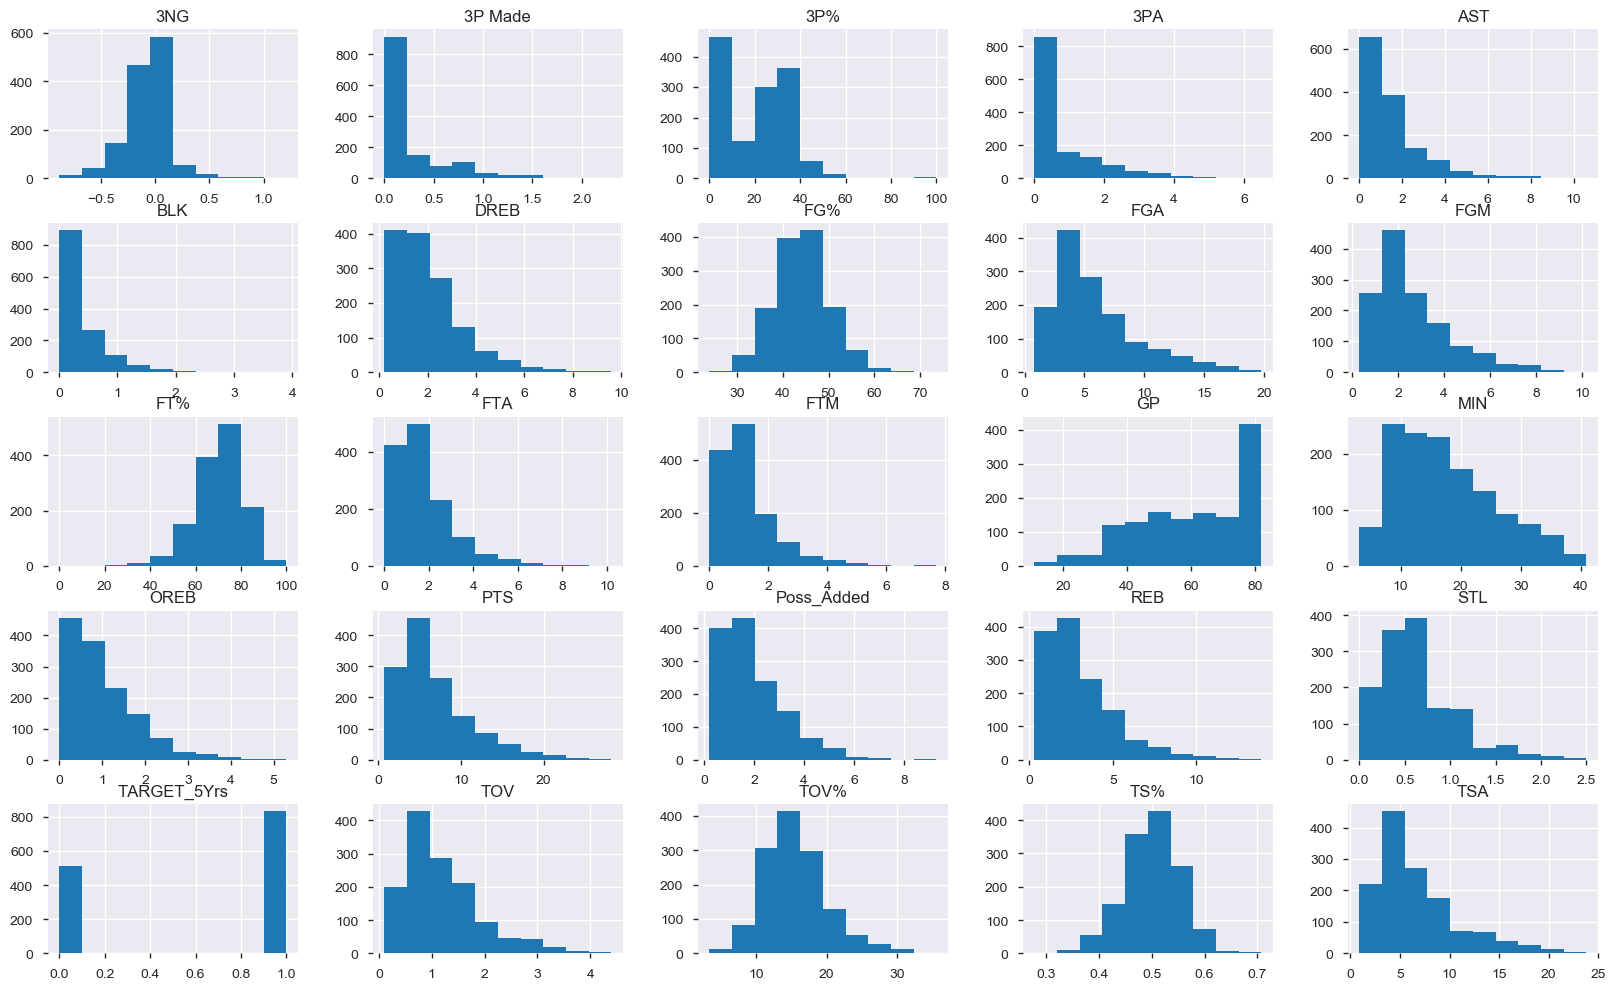

In [12]:
#Closer look at the histograms
raw_df.hist(figsize=(20,12));

In [16]:
#a random slice to verify accuracy of the "0" class
raw_df[raw_df['TARGET_5Yrs'] == 0].iloc[10:20,:]

Name  GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  \
18      Larry Johnson  82  37.2  19.2  7.5  15.3  49.0      0.1  0.3  22.7   
23       Steven Smith  61  29.6  12.0  4.9  10.7  45.4      0.7  2.0  32.0   
24       Mitch McGary  32  15.2   6.3  2.8   5.2  53.3      0.0  0.1   0.0   
26     Mike Iuzzolino  52  24.6   9.3  3.1   6.8  45.1      1.1  2.6  43.4   
28        Paul Graham  78  22.0  10.1  3.9   8.7  44.7      0.7  1.8  39.0   
34  Spencer Dinwiddie  34  13.4   4.3  1.5   5.0  30.2      0.4  1.9  18.5   
40        Kevin Lynch  55  14.9   4.1  1.7   4.1  41.7      0.1  0.1  37.5   
41   LaBradford Smith  48  14.8   5.1  2.1   5.1  40.7      0.0  0.4   9.5   
42    Chris Corchiani  51  14.5   5.0  1.5   3.8  39.9      0.2  0.7  27.0   
43        Travis Wear  51  13.2   3.9  1.6   4.1  40.2      0.2  0.6  36.7   

       ...      AST  STL  BLK  TOV  TARGET_5Yrs     TSA       TS%    3NG  \
18     ...      3.6  1.0  0.6  1.9          0.0  17.500  0.548571 -0.018   
23     ...      4.6  1.0  0.3  2.5          0.0  11.624  0.516173 -0.020   
24     ...      0.4  0.5  0.5  1.0          0.0   5.772  0.545738 -0.106   
26     ...      3.7  0.6  0.0  1.8          0.0   7.900  0.588608  0.544   
28     ...      2.2  1.2  0.3  1.2          0.0   9.668  0.522342  0.192   
34     ...      3.1  0.6  0.2  1.0          0.0   5.440  0.395221 -0.814   
40     ...      1.5  0.7  0.2  0.8          0.0   4.452  0.460467  0.194   
41     ...      2.1  0.9  0.0  1.3          0.0   5.628  0.453092 -0.424   
42     ...      2.8  0.9  0.0  1.4          0.0   4.680  0.534188 -0.142   
43     ...      0.8  0.3  0.2  0.7          0.0   4.320  0.451389 -0.036   

         TOV%  Poss_Added  
18   9.793814         5.5  
23  17.700368         2.6  
24  14.766686         2.7  
26  18.556701         1.1  
28  11.041590         2.4  
34  15.527950         0.9  
40  15.232292         1.4  
41  18.764434         1.5  
42  23.026316         1.3  
43  13.944223         1.1  

[10 rows x 26 columns]

- A bit of a sloppy dataset in general...Larry Johnson (aka "Grandmama", the legendary Charlotte Hornet!) is misclassified as a "0".  
- "Steven Smith" only played for one year with different stats, but "Steve Smith" matches the stats provided in row 23.

In [17]:
raw_df[raw_df['Name'] == 'Patrick Ewing']

Name  GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA  3P%  \
314  Patrick Ewing  50  35.4  20.0  7.7  16.3  47.4      0.0  0.1  0.0   

        ...      AST  STL  BLK  TOV  TARGET_5Yrs     TSA       TS%    3NG  \
314     ...      2.0  1.1  2.1  3.4          0.0  18.984  0.526759 -0.106   

          TOV%  Poss_Added  
314  15.189421         5.7  

[1 rows x 26 columns]

Some other clear misclassifications in the target...like Hall of Famer Patrick Ewing in the wrong class!

In [18]:
raw_df[raw_df.duplicated(subset=['Name', 'GP'], keep = False)]

Name  GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  \
18       Larry Johnson  82  37.2  19.2  7.5  15.3  49.0      0.1  0.3  22.7   
19       Larry Johnson  82  37.2  19.2  7.5  15.3  49.0      0.1  0.3  22.7   
71           Dee Brown  82  23.7   8.7  3.5   7.5  46.4      0.1  0.4  20.6   
72           Dee Brown  82  23.7   8.7  3.5   7.5  46.4      0.1  0.4  20.6   
73           Dee Brown  49   9.2   1.9  0.7   2.0  32.7      0.1  0.6  21.4   
74           Dee Brown  49   9.2   1.9  0.7   2.0  32.7      0.1  0.6  21.4   
120       Tim Hardaway  79  33.7  14.7  5.9  12.5  47.1      0.3  1.1  27.4   
121       Tim Hardaway  79  33.7  14.7  5.9  12.5  47.1      0.3  1.1  27.4   
126          Glen Rice  77  30.0  13.6  6.1  13.9  43.9      0.2  0.9  24.6   
127          Glen Rice  77  30.0  13.6  6.1  13.9  43.9      0.2  0.9  24.6   
156      Michael Smith  65   9.5   5.0  2.1   4.4  47.6      0.0  0.4   7.1   
157      Michael Smith  65   9.5   5.0  2.1   4.4  47.6      0.0  0.4   7.1   
158      Michael Smith  82  21.2   6.9  2.7   5.0  54.2      0.0  0.0   0.0   
159      Michael Smith  82  21.2   6.9  2.7   5.0  54.2      0.0  0.0   0.0   
162      Charles Smith  60   8.7   2.9  1.0   2.2  44.4      0.0  0.1   0.0   
163      Charles Smith  60   8.7   2.9  1.0   2.2  44.4      0.0  0.1   0.0   
164      Charles Smith  60   8.7   2.9  1.0   2.2  44.4      0.0  0.1   0.0   
165      Charles Smith  71  30.4  16.3  6.1  12.4  49.5      0.0  0.0   0.0   
166      Charles Smith  71  30.4  16.3  6.1  12.4  49.5      0.0  0.0   0.0   
167      Charles Smith  71  30.4  16.3  6.1  12.4  49.5      0.0  0.0   0.0   
168      Charles Smith  34   8.6   3.5  1.4   3.7  39.2      0.4  1.4  31.9   
169      Charles Smith  34   8.6   3.5  1.4   3.7  39.2      0.4  1.4  31.9   
170      Charles Smith  34   8.6   3.5  1.4   3.7  39.2      0.4  1.4  31.9   
223         Mark Davis  33   7.8   3.8  1.5   3.1  48.0      0.0  0.3  10.0   
224         Mark Davis  33   7.8   3.8  1.5   3.1  48.0      0.0  0.3  10.0   
225         Mark Davis  57  10.0   3.3  1.0   2.6  36.9      0.1  0.2  30.8   
226         Mark Davis  57  10.0   3.3  1.0   2.6  36.9      0.1  0.2  30.8   
242    Reggie Williams  35  24.5  10.4  4.3  12.2  35.6      0.4  1.7  22.4   
243    Reggie Williams  35  24.5  10.4  4.3  12.2  35.6      0.4  1.7  22.4   
338        Ken Johnson  64  12.7   4.1  1.8   3.3  52.8      0.0  0.0   NaN   
339        Ken Johnson  64  12.7   4.1  1.8   3.3  52.8      0.0  0.0   NaN   
364      Charles Jones  78  20.1   8.4  3.0   5.8  52.0      0.0  0.1   0.0   
365      Charles Jones  78  20.1   8.4  3.0   5.8  52.0      0.0  0.1   0.0   
366      Charles Jones  78  20.1   8.4  3.0   5.8  52.0      0.0  0.1   0.0   
367      Charles Jones  29  16.4   3.7  1.3   4.2  31.7      0.7  2.1  31.1   
368      Charles Jones  29  16.4   3.7  1.3   4.2  31.7      0.7  2.1  31.1   
369      Charles Jones  29  16.4   3.7  1.3   4.2  31.7      0.7  2.1  31.1   
472     Walker Russell  68  11.1   2.7  1.0   2.7  36.4      0.0  0.3  11.1   
473     Walker Russell  68  11.1   2.7  1.0   2.7  36.4      0.0  0.3  11.1   
503      Eddie Johnson  74  20.5   9.3  4.0   8.7  45.9      0.0  0.1   9.1   
504      Eddie Johnson  74  20.5   9.3  4.0   8.7  45.9      0.0  0.1   9.1   
553         Larry Drew  76  20.8   6.6  2.6   6.4  40.7      0.1  0.2  23.5   
554         Larry Drew  76  20.8   6.6  2.6   6.4  40.7      0.1  0.2  23.5   
732   Gerald Henderson  43   8.3   2.6  0.9   2.4  35.6      0.1  0.4  21.1   
733   Gerald Henderson  43   8.3   2.6  0.9   2.4  35.6      0.1  0.4  21.1   
823    Marcus Williams  79  16.6   6.8  2.6   6.7  39.5      0.6  2.1  28.2   
824    Marcus Williams  79  16.6   6.8  2.6   6.7  39.5      0.6  2.1  28.2   
848        Bobby Jones  44   7.6   2.5  1.0   2.1  46.2      0.0  0.2  11.1   
849        Bobby Jones  44   7.6   2.5  1.0   2.1  46.2      0.0  0.2  11.1   
870          David Lee  67  16.9   5.1  2.0   3.4  59.6      0.0  0.

A LOT of duplicate rows to deal with.  Many have the exact same values except in the target column, where one is correctly classified and the other incorrect (eg. Larry Johnson on the top two rows of the output above).

In [19]:
dupes_to_drop = raw_df.index[[18,71,74,120,127,157,158,162,163,166,167,169,170,223,226,243,339,364,365,367,368,
                          472,504,554,733,824,848,871,971,1127,1229,1335]]

In [20]:
raw_df.drop(dupes_to_drop, inplace=True)

In [21]:
raw_df[raw_df.duplicated(subset='Name', keep=False)]

Name  GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  \
72           Dee Brown  82  23.7   8.7  3.5   7.5  46.4      0.1  0.4  20.6   
73           Dee Brown  49   9.2   1.9  0.7   2.0  32.7      0.1  0.6  21.4   
156      Michael Smith  65   9.5   5.0  2.1   4.4  47.6      0.0  0.4   7.1   
159      Michael Smith  82  21.2   6.9  2.7   5.0  54.2      0.0  0.0   0.0   
164      Charles Smith  60   8.7   2.9  1.0   2.2  44.4      0.0  0.1   0.0   
165      Charles Smith  71  30.4  16.3  6.1  12.4  49.5      0.0  0.0   0.0   
168      Charles Smith  34   8.6   3.5  1.4   3.7  39.2      0.4  1.4  31.9   
197   Michael Anderson  36  20.3   5.7  2.0   4.9  41.7      0.0  0.2  14.3   
198   Michael Anderson  65  18.5   7.4  2.9   5.8  50.1      0.0  0.1   0.0   
208        Mark Bryant  56  14.3   5.0  2.1   4.4  48.6      0.0  0.0   0.0   
209        Mark Bryant  36   7.0   1.6  0.7   1.6  43.1      0.0  0.0   0.0   
224         Mark Davis  33   7.8   3.8  1.5   3.1  48.0      0.0  0.3  10.0   
225         Mark Davis  57  10.0   3.3  1.0   2.6  36.9      0.1  0.2  30.8   
311         Bob Martin  43   6.7   3.4  1.2   3.1  37.8      0.1  0.3  20.0   
312         Bob Martin  53  10.1   2.1  0.8   1.7  45.5      0.0  0.0   0.0   
366      Charles Jones  78  20.1   8.4  3.0   5.8  52.0      0.0  0.1   0.0   
369      Charles Jones  29  16.4   3.7  1.3   4.2  31.7      0.7  2.1  31.1   
460        Jeff Taylor  44  17.6   3.6  1.5   3.6  40.0      0.0  0.0   0.0   
461        Jeff Taylor  77  19.6   6.1  2.2   5.2  43.1      0.7  2.0  34.4   
565      James Johnson  68  14.4   5.3  1.9   3.5  54.2      0.0  0.0   0.0   
566      James Johnson  65  11.6   3.9  1.5   3.2  45.2      0.2  0.7  32.6   
767     Cory Alexander  59  12.1   4.7  1.7   4.2  41.6      0.3  0.8  34.8   
768     Cory Alexander  60   9.3   2.8  1.1   2.6  40.6      0.4  1.1  39.4   
959      Carlos Rogers  81  25.3  10.0  4.1   7.6  53.6      0.0  0.0   0.0   
960      Carlos Rogers  49  20.8   8.9  3.7   6.9  52.9      0.0  0.3  14.3   
1093       Jamie Feick  28  30.4   6.3  2.4   4.8  50.0      0.0  0.0   0.0   
1094       Jamie Feick  41  15.2   3.7  1.4   3.8  35.7      0.1  0.3  35.7   

         ...      AST  STL  BLK  TOV  TARGET_5Yrs     TSA       TS%    3NG  \
72       ...      4.2  1.0  0.2  1.7          1.0   8.336  0.521833 -0.124   
73       ...      1.7  0.5  0.1  0.6          0.0   2.352  0.403912 -0.336   
156      ...      1.2  0.1  0.0  0.8          0.0   4.840  0.516529 -0.424   
159      ...      0.8  0.7  0.6  1.3          1.0   6.408  0.538390  0.000   
164      ...      1.7  0.6  0.1  0.6          0.0   2.772  0.523088 -0.106   
165      ...      1.5  1.0  1.3  2.1          1.0  14.820  0.549933  0.000   
168      ...      0.6  0.3  0.2  0.8          1.0   3.832  0.456681 -0.284   
197      ...      4.3  1.2  0.1  2.3          0.0   5.912  0.482070 -0.212   
198      ...      1.0  1.0  0.3  1.2          0.0   6.988  0.529479 -0.106   
208      ...      0.6  0.4  0.1  0.7          1.0   4.928  0.507305  0.000   
209      ...      0.2  0.1  0.1  0.3          1.0   1.776  0.450450  0.000   
224      ...      0.4  0.4  0.1  0.4          0.0   3.540  0.536723 -0.318   
225      ...      0.8  0.7  0.4  1.2          1.0   3.480  0.474138  0.088   
311      ...      0.8  0.3  0.1  0.8          0.0   3.760  0.452128 -0.018   
312      ...      0.3  0.1  0.6  0.6          0.0   2.140  0.490654  0.000   
366      ...      1.6  0.6  0.8  1.8          0.0   7.384  0.568797 -0.106   
369      ...      1.4  0.6  0.2  1.0          0.0   4.552  0.406415 -0.126   
460      ...      2.5  0.9  0.3  1.4          0.0   4.040  0.445545  0.000   
461      ...      0.8  0.6  0.2  0.6          0.0   5.772  0.528413 -0.020   
565      ...      0.6  0.1  1.1  1.0          1.0   4.600  0.576087  0.000   
566      ...      0.7  0.3  0.7  0.9          1.0   3.684  0.529316 -0.142   
767      ...      0.7  0.3  0.5  0.9          1.0   4.816  0.487957  0.052   
768      ..

Still a number of things to clean up.  This was a bit labor intensive, but I tracked down several name corrections that explained the remaining duplicate names, as well as a handful of other misclassifications.  The 2nd Jaime Feick at index 1093 remained a mystery, so he went to the trash heap.

 - Michael Anderson 198 = J.J. Anderson
 - Mark Bryant 209 = Mark Bradtke and should be 0
 - Bob Martin 311 = Maurice (Mo) Martin
 - James Johnson 565 = James Donaldson
 - Cory Alexander 767 = Joe Alexander and should be 0
 - Carlos Rogers 959 = Carlos Boozer
 - Jamie Feick 1093...can't figure this one out after a deep dive, so we're dropping this row
 - Patrick Ewing should be 1
 - Jamal Robinson  = Rumeal Robinson and should be 1
 - Steven Smith should be Steve Smith (1991 draft)

In [22]:
raw_df.loc[198, 'Name'] = 'J.J. Anderson'
raw_df.loc[209, ['Name', 'TARGET_5Yrs']] = ['Mark Bradtke', 0.0]
raw_df.loc[311, 'Name'] = 'Maurice "Mo" Martin'
raw_df.loc[565, 'Name'] = 'James Donaldson'
raw_df.loc[767, ['Name', 'TARGET_5Yrs']] = ['Joe Alexander', 0.0]
raw_df.loc[959, 'Name'] = 'Carlos Boozer'
raw_df.loc[23, 'Name'] = 'Steve Smith'
raw_df.loc[314, 'TARGET_5Yrs'] = 1.0
raw_df.loc[90, ['Name', 'TARGET_5Yrs']] = ['Rumeal Robinson', 1.0]
raw_df.drop(1093, axis=0, inplace=True)

In [23]:
#sanity check
raw_df[raw_df['Name'] == 'Jamie Feick']

Name  GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  \
1094  Jamie Feick  41  15.2  3.7  1.4  3.8  35.7      0.1  0.3  35.7   

         ...      AST  STL  BLK  TOV  TARGET_5Yrs    TSA       TS%    3NG  \
1094     ...      0.6  0.4  0.3  0.8          1.0  4.504  0.410746 -0.018   

           TOV%  Poss_Added  
1094  15.082956         2.7  

[1 rows x 26 columns]

In [24]:
raw_df.shape

(1307, 26)

In [25]:
import csv

#misclassified = []
with open('nba_log_reg_csv.csv', 'r', encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    misclassified = list(reader)

print(misclassified)

[['Spencer Dinwiddie', 'Gary Harris', 'Kyle Anderson', 'Noah Vonleh', 'Michael Carter-Williams', 'Kentavious Caldwell-Pope', 'Mason Plumlee', 'Cody Zeller', 'Tony Snell', 'Dewayne Dedmon', 'Jeff Withey', 'Andre Roberson', 'Reggie Bullock', 'Otto Porter', 'Solomon Hill', 'Shabazz Muhammad', 'Damian Lillard', 'Bradley Beal', 'Anthony Davis', 'Dion Waiters', 'Kyle Singler', 'Tyler Zeller', 'Maurice Harkless', 'Michael Kidd-Gilchrist', 'Harrison Barnes', 'Austin Rivers', 'Andre Drummond', 'Meyers Leonard', 'Patrick Beverley', 'Jae Crowder', 'Brian Roberts', 'Terrence Ross', 'Thomas Robinson', 'John Jenkins', 'Draymond Green', 'John Henson', 'Will Barton', "Kyle O'Quinn", 'Mike Scott', 'Jeremy Lamb', 'Langston Galloway', 'Nerlens Noel', 'Elfrid Payton', 'Jabari Parker', 'Marcus Smart', 'Jordan Clarkson', 'Zach LaVine', 'Rodney Hood', 'Jerami Grant', 'Shabazz Napier', 'Tyler Johnson', 'Aaron Gordon']]


In [26]:
with open('nba_logreg_holdout.csv', 'r', encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    unknown = list(reader)

print(unknown)

[['Brandon Ingram', 'Andrew Harrison', 'JaKarr Sampson', 'Troy Williams', 'Marquese Chriss', 'Kris Dunn', 'Malcolm Delaney', 'Semaj Christon', 'Caris LeVert', 'Sheldon McClellan', 'Rodney McGruder', 'Patrick McCaw', 'Kay Felder', 'Denzel Valentine', 'Karl-Anthony Towns', 'Justise Winslow', "D'Angelo Russell", 'Devin Booker', 'Stanley Johnson', 'Myles Turner', 'Willie Cauley-Stein', 'Josh Richardson', 'Rondae Hollis-Jefferson', 'Frank Kaminsky', 'Anthony Brown', 'Larry Nance Jr.', 'Malcolm Brogdon', 'Bobby Portis', 'Jerian Grant', 'Tyus Jones', 'Chris McCullough', 'Norman Powell', 'Jonathon Simmons', 'Dorian Finney-Smith', 'Rashad Vaughn', 'Jarell Martin', 'Richaun Holmes', 'Cameron Payne', 'Justin Anderson', 'Lamar Patterson', 'Willie Reed', 'Isaiah Whitehead', 'Darrun Hilliard', 'Domantas Sabonis', 'Adreian Payne']]


In [27]:
len(unknown[0])

45

In [28]:
unk_2016 = ['Brandon Ingram', 'Andrew Harrison', 'Troy Williams', 'Marquese Chriss', 'Kris Dunn', 'Malcolm Delaney',
            'Semaj Christon', 'Caris LeVert', 'Sheldon McClellan', 'Rodney McGruder', 'Patrick McCaw', 'Kay Felder', 
            'Denzel Valentine', 'Karl-Anthony Towns', 'Malcolm Brogdon', 'Dorian Finney-Smith', 'Isaiah Whitehead', 'Domantas Sabonis' ]
            
            
unk_2015 = ['Justise Winslow', "D'Angelo Russell", 'Devin Booker', 'Stanley Johnson', 'Myles Turner', 'Willie Cauley-Stein',
            'Josh Richardson', 'Rondae Hollis-Jefferson', 'Frank Kaminsky', 'Anthony Brown', 'Larry Nance Jr.', 'Bobby Portis', 
            'Jerian Grant', 'Tyus Jones', 'Chris McCullough', 'Norman Powell', 'Jonathon Simmons', 'Rashad Vaughn', 'Jarell Martin', 
            'Richaun Holmes', 'Cameron Payne', 'Justin Anderson', 'Lamar Patterson', 'Willie Reed', 'Darrun Hilliard', 'Adreian Payne']

In [29]:
print(len(unk_2015))
print(len(unk_2016))

26
18


OK good we got them all...JaKarr Sampson was in the unknown file by mistake, so it should be 44 total names

In [30]:
for index, row in raw_df.iterrows():
    if row['Name'] in misclassified[0]:
        raw_df.loc[index, 'TARGET_5Yrs'] = 1.0


In [31]:
for index, row in raw_df.iterrows():
    if row['Name'] in unk_2016:
        raw_df.drop(index, axis=0, inplace=True)

In [32]:
new_df = raw_df.copy()

In [33]:
for index, row in raw_df.iterrows():
    if row['Name'] in unk_2015:
        raw_df.drop(index, axis=0, inplace=True)

So this is the last bit of major housekeeping needed.  The above steps were necessary because:
 - This dataset appears to have been published in 2017, but included a decent-sized sample of players that hadn't had the opportunity to play 5 years yet.  Those were all classified as "0" by default, regardless of how promising their career potential was based on stats accumulated to date.
 - For players drafted in 2016 specifically, the stats were all for a partial season (accumulated through 12-31-16, which is roughly the halfway point of the season).  All the data is incorrect and might bias the model, so those rows were dropped.  Of particular importance is the Games Played value, which is artificially deflated (as we'll see later, this is generally the most important feature in our models).
 - Players drafted in 2014 or earlier had reached a point where we could apply an accurate ground-truth label at the time of this analysis.  All who DID successfully reach the 5-year mark are in the first file/list, "misclassified".
 - Players drafted in 2015 were dropped from the first df but remain on the copy, as we may choose to use those to make some predictions once we've tuned a final model.  We can make pretty sound educated guesses as to who will/won't survive the 5 year guantlet at this stage, so we'll see if the model agrees with our own predictions having seen their career stats from 2015-2019.  However, we'll exclude this data from the training/testing set since they're all classified as "0" by default and we can't assign ground-truth labels just yet.

In [34]:
print(raw_df.shape)
print(new_df.shape)

(1263, 26)
(1289, 26)


In [35]:
#sanity check that the target labels are changed for misclassified list
raw_df[raw_df['Name'] == 'Gary Harris']

Name  GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  \
64  Gary Harris  55  13.1  3.4  1.2  3.9  30.4      0.4  1.9  20.4   

       ...      AST  STL  BLK  TOV  TARGET_5Yrs    TSA       TS%    3NG  \
64     ...      0.5  0.7  0.1  0.7          1.0  4.296  0.395717 -0.814   

         TOV%  Poss_Added  
64  14.011209         1.2  

[1 rows x 26 columns]

## Dealing with Null Values

In [36]:
raw_df.isna().any().any()

True

In [37]:
raw_df.isnull().sum()

Name            0
GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            10
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
TSA             0
TS%             0
3NG             0
TOV%            0
Poss_Added      0
dtype: int64

In [38]:
raw_df[raw_df['3P%'].isnull()]

Name  GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA  3P%  \
338     Ken Johnson  64  12.7   4.1  1.8  3.3  52.8      0.0  0.0  NaN   
340   Pete Williams  53  10.8   2.8  1.3  2.1  60.4      0.0  0.0  NaN   
358   Melvin Turpin  79  24.7  10.6  4.6  9.0  51.1      0.0  0.0  NaN   
386    Jim Petersen  60  11.9   3.2  1.2  2.4  48.6      0.0  0.0  NaN   
397   Tom Scheffler  39   6.9   1.3  0.5  1.3  41.2      0.0  0.0  NaN   
507    Sam Williams  59  18.2   6.1  2.6  4.7  55.6      0.0  0.0  NaN   
509   Kurt Nimphius  63  17.2   5.3  2.2  4.7  46.1      0.0  0.0  NaN   
510  Pete Verhoeven  71  17.0   4.9  2.1  4.2  50.3      0.0  0.0  NaN   
521       Jim Smith  72  11.9   2.9  1.2  2.3  50.9      0.0  0.0  NaN   
559    Jeff Wilkins  56  18.9   4.7  2.1  4.6  45.0      0.0  0.0  NaN   

        ...      AST  STL  BLK  TOV  TARGET_5Yrs    TSA       TS%  3NG  \
338     ...      0.3  0.2  0.3  0.9          0.0  3.872  0.529442  0.0   
340     ...      0.3  0.4  0.4  0.4          0.0  2.452  0.570962  0.0   
358     ...      0.5  0.5  1.1  1.5          1.0  9.792  0.541258  0.0   
386     ...      0.5  0.2  0.5  1.2          1.0  2.884  0.554785  0.0   
397     ...      0.3  0.2  0.3  0.4          0.0  1.520  0.427632  0.0   
507     ...      0.6  0.8  1.3  1.1          0.0  5.360  0.569030  0.0   
509     ...      1.0  0.3  1.3  0.9          1.0  5.448  0.486417  0.0   
510     ...      0.7  0.6  0.3  0.8          1.0  4.640  0.528017  0.0   
521     ...      0.6  0.3  0.7  0.7          0.0  2.828  0.512730  0.0   
559     ...      0.7  0.6  0.8  1.1          1.0  4.908  0.478810  0.0   

          TOV%  Poss_Added  
338  18.860017         1.9  
340  14.025245         1.7  
358  13.283741         3.6  
386  29.382958         1.4  
397  20.833333         1.0  
507  17.027864         3.6  
509  14.177694         3.1  
510  14.705882         2.4  
521  19.841270         2.0  
559  18.308921         2.5  

[10 rows x 26 columns]

In [42]:
raw_df['3P%'].fillna(0, inplace=True)

In [43]:
raw_df.isna().any().any()

False

These null values were all a result of attempting to divide by 0 since they all had 0 3P attempts, so we can safely fill the values with 0% and move on.

# Heat Check (Heatmaps for Multicollinearity)

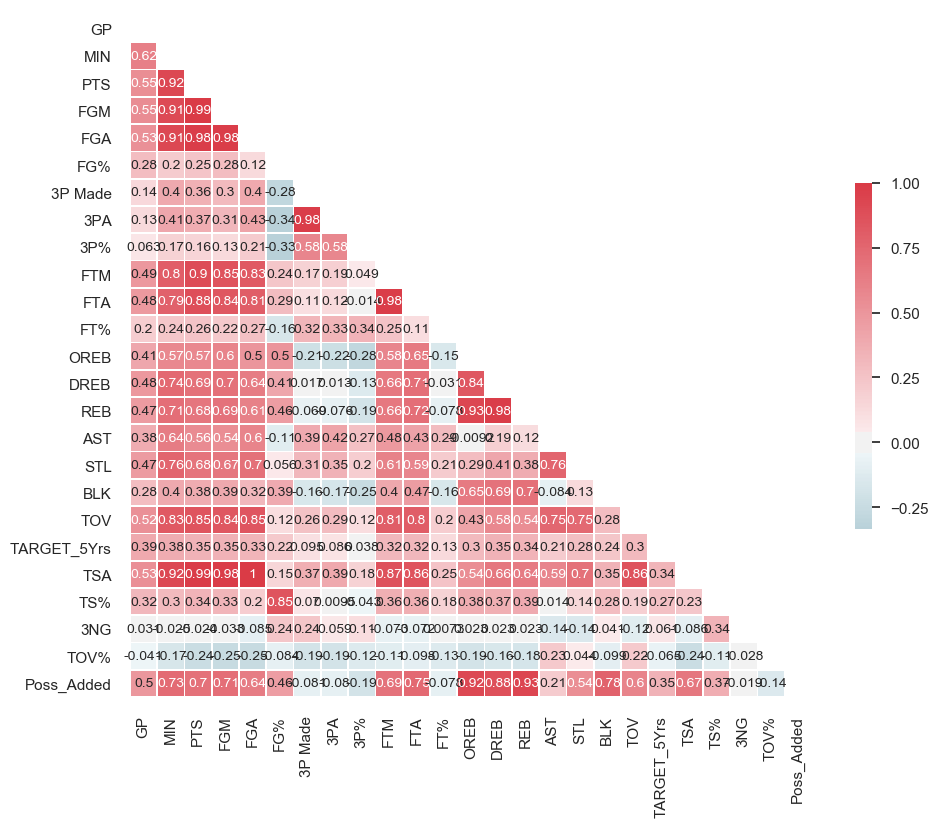

In [44]:
draw_heatmap(raw_df);

That is a LOT of deep red!  Let's use the Profile Report's "rejections" (with some slight tweaks) to determine which to drop so we don't spend too much time here.  I've opted to remove OREB and DREB while keeping REB and will also remove TOV since it's highly correlated with a number of features we'll keep.  We also engineered TOV% which should stand in nicely.

In [45]:
slim_df = raw_df.drop(['PTS', '3PA', 'FGA', 'FGM', 'FTA', 'OREB', 'DREB', 'TOV', 'Poss_Added', 'TSA'], axis=1)

In [46]:
slim_df.head()

Name  GP   MIN   FG%  3P Made   3P%  FTM   FT%  REB  AST  STL  \
2  JaKarr Sampson  74  15.3  42.2      0.4  24.4  0.9  67.0  2.2  1.0  0.5   
3     Malik Sealy  58  11.6  42.6      0.1  22.6  0.9  68.9  1.9  0.8  0.6   
4     Matt Geiger  48  11.5  52.4      0.0   0.0  1.3  67.4  2.5  0.3  0.3   
5    Tony Bennett  75  11.4  42.3      0.3  32.5  0.4  73.2  0.8  1.8  0.4   
6     Don MacLean  62  10.9  43.5      0.0  50.0  1.5  81.1  2.0  0.6  0.2   

   BLK  TARGET_5Yrs       TS%    3NG       TOV%  
2  0.3          0.0  0.493171 -0.602  15.943878  
3  0.1          1.0  0.469368 -0.230  14.140271  
4  0.4          1.0  0.586548 -0.106  17.256255  
5  0.0          0.0  0.497312 -0.266  15.837104  
6  0.1          1.0  0.500607 -0.106   9.599561

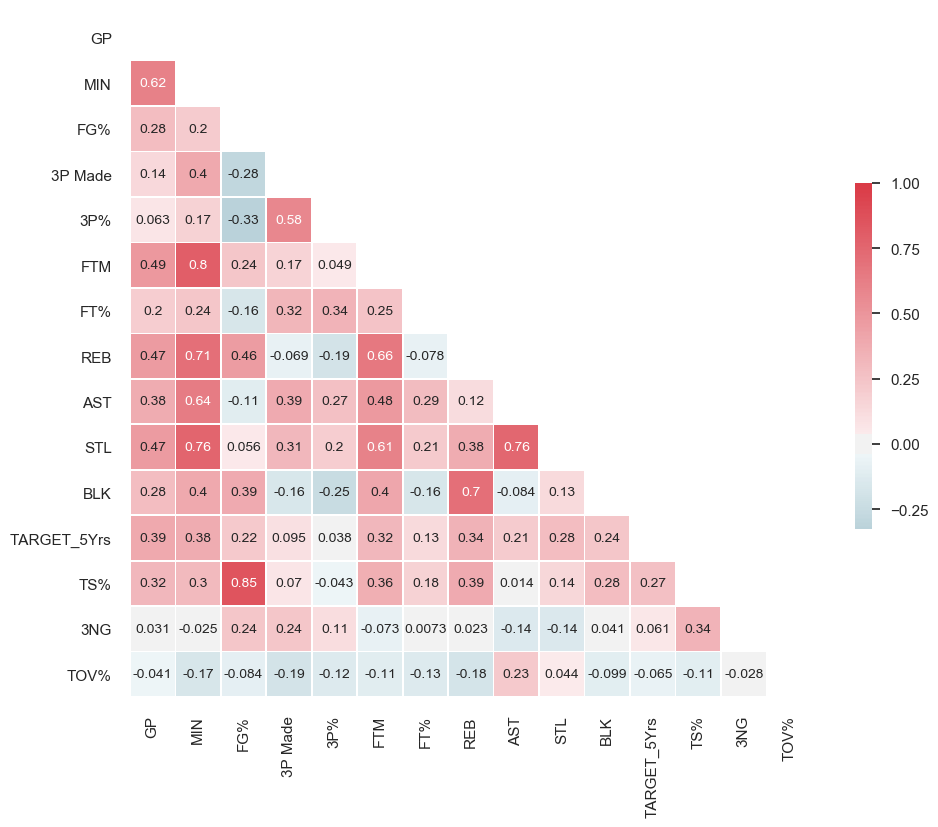

In [47]:
draw_heatmap(slim_df);

This looks acceptable even though there are a couple values sprinkled in here that are a bit uncomfortable.  If we end up using Logistic Regression as our final model, we may revisit this to ensure there isn't too much noise injected into our model because of these relationships.

# Modeling Our Data

At long last, we're ready to move on to modeling our data.  We'll do a bit more preprocessing here by creating two different sets of target and feature variables.

In [48]:
np.random.seed(2)

In [49]:
target = raw_df['TARGET_5Yrs']
feat = raw_df.drop('TARGET_5Yrs', axis=1)

In [50]:
feat.head()

Name  GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  \
2  JaKarr Sampson  74  15.3  5.2  2.0  4.7  42.2      0.4  1.7  24.4   
3     Malik Sealy  58  11.6  5.7  2.3  5.5  42.6      0.1  0.5  22.6   
4     Matt Geiger  48  11.5  4.5  1.6  3.0  52.4      0.0  0.1   0.0   
5    Tony Bennett  75  11.4  3.7  1.5  3.5  42.3      0.3  1.1  32.5   
6     Don MacLean  62  10.9  6.6  2.5  5.8  43.5      0.0  0.1  50.0   

      ...      REB  AST  STL  BLK  TOV    TSA       TS%    3NG       TOV%  \
2     ...      2.2  1.0  0.5  0.3  1.0  5.272  0.493171 -0.602  15.943878   
3     ...      1.9  0.8  0.6  0.1  1.0  6.072  0.469368 -0.230  14.140271   
4     ...      2.5  0.3  0.3  0.4  0.8  3.836  0.586548 -0.106  17.256255   
5     ...      0.8  1.8  0.4  0.0  0.7  3.720  0.497312 -0.266  15.837104   
6     ...      2.0  0.6  0.2  0.1  0.7  6.592  0.500607 -0.106   9.599561   

   Poss_Added  
2         1.3  
3         1.7  
4         1.7  
5         0.6  
6         0.8  

[5 rows x 25 columns]

In [51]:
target.head()

2    0.0
3    1.0
4    1.0
5    0.0
6    1.0
Name: TARGET_5Yrs, dtype: float64

In [52]:
slim_target = slim_df['TARGET_5Yrs']
slim_feat = slim_df.drop('TARGET_5Yrs', axis=1)

A quick glance back at our target variable distribution:

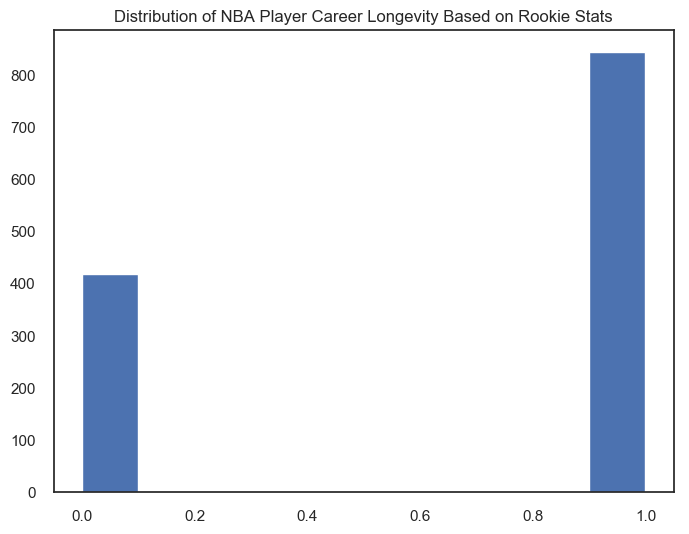

In [53]:
plt.figure(figsize=(8,6))
plt.title('Distribution of NBA Player Career Longevity Based on Rookie Stats')
plt.hist(raw_df.TARGET_5Yrs)
plt.show();


In [54]:
target.value_counts(normalize=True)

1.0    0.66825
0.0    0.33175
Name: TARGET_5Yrs, dtype: float64

So this is our baseline accuracy, just under 67%.  In other words, if we created a "dumb" model that predicted that ALL players would successfully reach the 5 year playing career threshold, we'd still be right about 67% of the time.

In [55]:
feat.set_index('Name', inplace=True)
slim_feat.set_index('Name', inplace=True)

We aren't using the Name column as a meaningful feature, so we might as well set it as the index for both.

In [56]:
#We'll need scaled data for some of the classifiers that aren't tree-based
scaler = StandardScaler()
scaled_feat = pd.DataFrame(scaler.fit_transform(slim_feat), columns=slim_feat.columns)
scaled_feat.head()

GP       MIN       FG%   3P Made       3P%       FTM       FT%  \
0  0.768543 -0.270461 -0.339061  0.415048  0.336174 -0.406816 -0.309953   
1 -0.172541 -0.713419 -0.273237 -0.366182  0.224918 -0.406816 -0.130093   
2 -0.760719 -0.725391  1.339449 -0.626592 -1.171954 -0.002561 -0.272088   
3  0.827361 -0.737362 -0.322605  0.154638  0.836822 -0.912135  0.276959   
4  0.062730 -0.797222 -0.125133 -0.626592  1.918471  0.199567  1.024799   

        REB       AST       STL       BLK       TS%       3NG      TOV%  
0 -0.403696 -0.369023 -0.281591 -0.159265 -0.154563 -2.532776  0.068065  
1 -0.550084 -0.503843 -0.039653 -0.620092 -0.604561 -0.739386 -0.329780  
2 -0.257308 -0.840896 -0.765469  0.071149  1.610674 -0.141590  0.357553  
3 -1.086839  0.170261 -0.523530 -0.850506 -0.076292 -0.912940  0.044512  
4 -0.501288 -0.638664 -1.007408 -0.620092 -0.014003 -0.141590 -1.331382

In [57]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(scaled_feat, target, test_size=0.25)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(feat, target, test_size=0.25)

A couple more helper functions that couldn't be defined before we executed our train test split since I use some of those variables as default arguments.

In [59]:
def plot_feature_importances(clf, X_train=X_train):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), clf.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")




In [60]:
def fit_predict_eval(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, name = None):
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    print('Accuracy for {} is {}'.format(name, round(accuracy_score(y_test, y_hat_test) *100), 4))
    print('-' * 60)
    print('Classification Report for {} Training Set:\n {}'.format(name, classification_report(y_train, y_hat_train)))
    print('-' * 60)
    print('Classification Report for {} Testing Set:\n {}'.format(name, classification_report(y_test, y_hat_test)))
    print('-' * 60)
    plot_cm(y_test, y_hat_test, title=name)

## Logistic Regression

Let's start with a Logistic Regression classifier first (only changing  a couple of the default parameters) to see if it improves upon our baseline.

In [61]:
logreg = LogisticRegression(fit_intercept=False, C=1e12)

Accuracy for Logistic Regression is 66.0
------------------------------------------------------------
Classification Report for Logistic Regression Training Set:
               precision    recall  f1-score   support

         0.0       0.53      0.78      0.63       317
         1.0       0.85      0.65      0.74       630

   micro avg       0.69      0.69      0.69       947
   macro avg       0.69      0.71      0.68       947
weighted avg       0.75      0.69      0.70       947

------------------------------------------------------------
Classification Report for Logistic Regression Testing Set:
               precision    recall  f1-score   support

         0.0       0.49      0.80      0.61       102
         1.0       0.86      0.60      0.71       214

   micro avg       0.66      0.66      0.66       316
   macro avg       0.68      0.70      0.66       316
weighted avg       0.74      0.66      0.67       316

------------------------------------------------------------


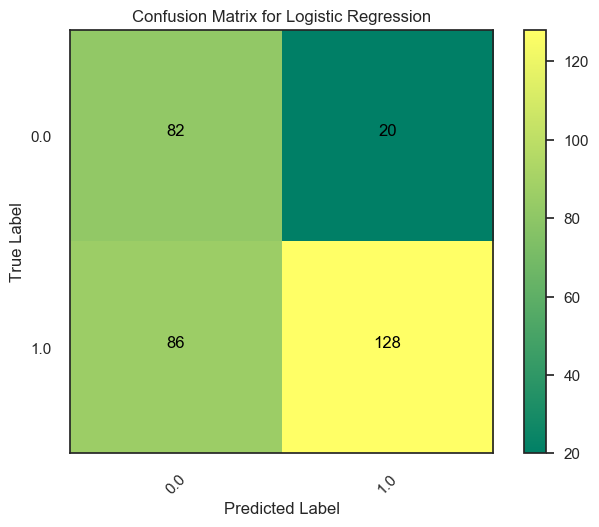

In [62]:
fit_predict_eval(logreg, X_train = X_train_sc, X_test = X_test_sc, y_train = y_train_sc, y_test = y_test_sc, name='Logistic Regression')

A pretty lousy result: accuracy and F1 are no better than the baseline.  Logistic Regression is a simple model so I didn't have high expecations.  But let's try one that's truly out of the box to see how the performance differs.

Accuracy for Logistic Regression 2 is 72.0
------------------------------------------------------------
Classification Report for Logistic Regression 2 Training Set:
               precision    recall  f1-score   support

         0.0       0.66      0.51      0.58       317
         1.0       0.78      0.87      0.82       630

   micro avg       0.75      0.75      0.75       947
   macro avg       0.72      0.69      0.70       947
weighted avg       0.74      0.75      0.74       947

------------------------------------------------------------
Classification Report for Logistic Regression 2 Testing Set:
               precision    recall  f1-score   support

         0.0       0.58      0.56      0.57       102
         1.0       0.79      0.80      0.80       214

   micro avg       0.72      0.72      0.72       316
   macro avg       0.68      0.68      0.68       316
weighted avg       0.72      0.72      0.72       316

--------------------------------------------------------

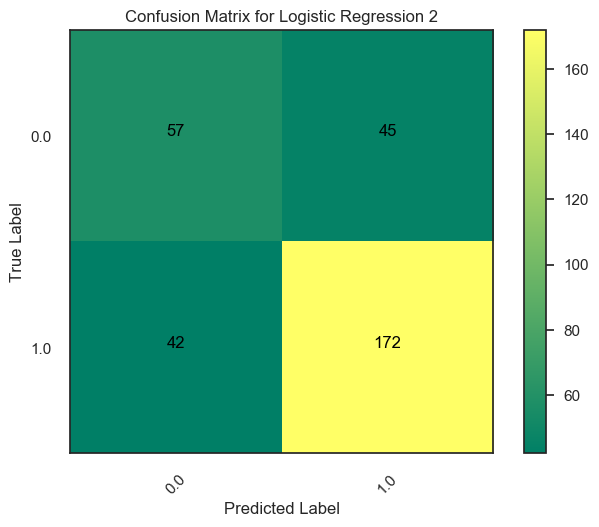

In [125]:
logreg2 = LogisticRegression()
fit_predict_eval(logreg2, X_train = X_train_sc, X_test = X_test_sc, y_train = y_train_sc, y_test = y_test_sc, name='Logistic Regression 2')

Considerably better and a decent improvement on our baseline.  However, we should be able to tune more complex models and see even more improvement.  Let's fit a bunch of other classifiers and compare initial results, then consider which ones we'll tune further.

In [63]:
from xgboost import XGBClassifier

In [64]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ab = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = xgb.XGBClassifier()

models = [logreg, knn, dt, rf, ab, gb, xgb]
model_names = ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost']

acc_scores = []
f1_scores = []
comp_time = []
for m in models:
    start = time.time()
    m.fit(X_train, y_train)
    y_preds = m.predict(X_test)
    end = time.time()
    acc_scores.append(round(accuracy_score(y_test, y_preds), 4))
    f1_scores.append(round(f1_score(y_test, y_preds), 4))
    comp_time.append(round((end-start),4))

In [65]:
results = pd.DataFrame({'Model Name': model_names, 'Accuracy Score': acc_scores, 'F1 Score': f1_scores, 'Computational Time': comp_time}).sort_values('Accuracy Score', ascending=False)
results

Model Name  Accuracy Score  F1 Score  Computational Time
0  Logistic Regression          0.7342    0.8117              0.0214
6              XGBoost          0.7342    0.8082              0.1222
3        Random Forest          0.7247    0.7953              0.0280
5    Gradient Boosting          0.7215    0.8044              0.1787
1  K-Nearest Neighbors          0.6930    0.7749              0.0091
4             AdaBoost          0.6899    0.7752              0.2113
2        Decision Tree          0.6677    0.7518              0.0131

I am using the full dataset here, which may be problematic for the non-tree based classifiers since it isn't scaled.  I'll try again using the scaled data, but I'll individually fit the appropriate set as we move through the models.

In [66]:
acc_scores2 = []
f1_scores2 = []
comp_time2 = []
for m in models:
    start = time.time()
    m.fit(X_train_sc, y_train_sc)
    y_preds = m.predict(X_test_sc)
    end = time.time()
    acc_scores2.append(round(accuracy_score(y_test_sc, y_preds), 4))
    f1_scores2.append(round(f1_score(y_test_sc, y_preds), 4))
    comp_time2.append(round((end-start),4))

In [67]:
results_2 = pd.DataFrame({'Model Name': model_names, 'Accuracy Score': acc_scores2, 'F1 Score': f1_scores2, 'Computational Time': comp_time2}).sort_values('Accuracy Score', ascending=False)
results_2

Model Name  Accuracy Score  F1 Score  Computational Time
0  Logistic Regression          0.7247    0.7981              0.0056
6              XGBoost          0.7184    0.7991              0.0718
4             AdaBoost          0.7152    0.7945              0.0841
5    Gradient Boosting          0.7025    0.7873              0.1025
1  K-Nearest Neighbors          0.6772    0.7594              0.0132
2        Decision Tree          0.6709    0.7559              0.0101
3        Random Forest          0.6709    0.7488              0.0248

So without tuning, it seems like Logistic Regression, Gradient Boosting, and XGBoost all perform well with this data.  However, decision trees and random forests are likely to overfit badly with default parameters, so this may be a bit miselading.

Let's choose a handful of these to see how much we can improve.

# Decision Tree

In [69]:
dt = DecisionTreeClassifier(criterion='entropy')

Accuracy for Decision Tree is 66.0
------------------------------------------------------------
Classification Report for Decision Tree Training Set:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       313
         1.0       1.00      1.00      1.00       634

   micro avg       1.00      1.00      1.00       947
   macro avg       1.00      1.00      1.00       947
weighted avg       1.00      1.00      1.00       947

------------------------------------------------------------
Classification Report for Decision Tree Testing Set:
               precision    recall  f1-score   support

         0.0       0.49      0.42      0.45       106
         1.0       0.73      0.78      0.75       210

   micro avg       0.66      0.66      0.66       316
   macro avg       0.61      0.60      0.60       316
weighted avg       0.65      0.66      0.65       316

------------------------------------------------------------


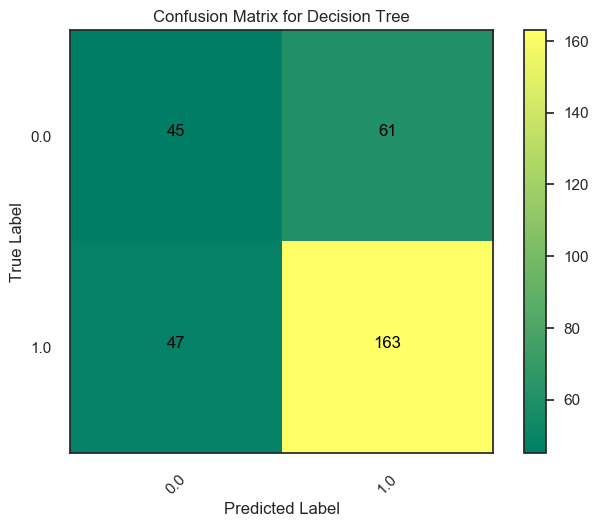

In [70]:
fit_predict_eval(dt, name='Decision Tree')

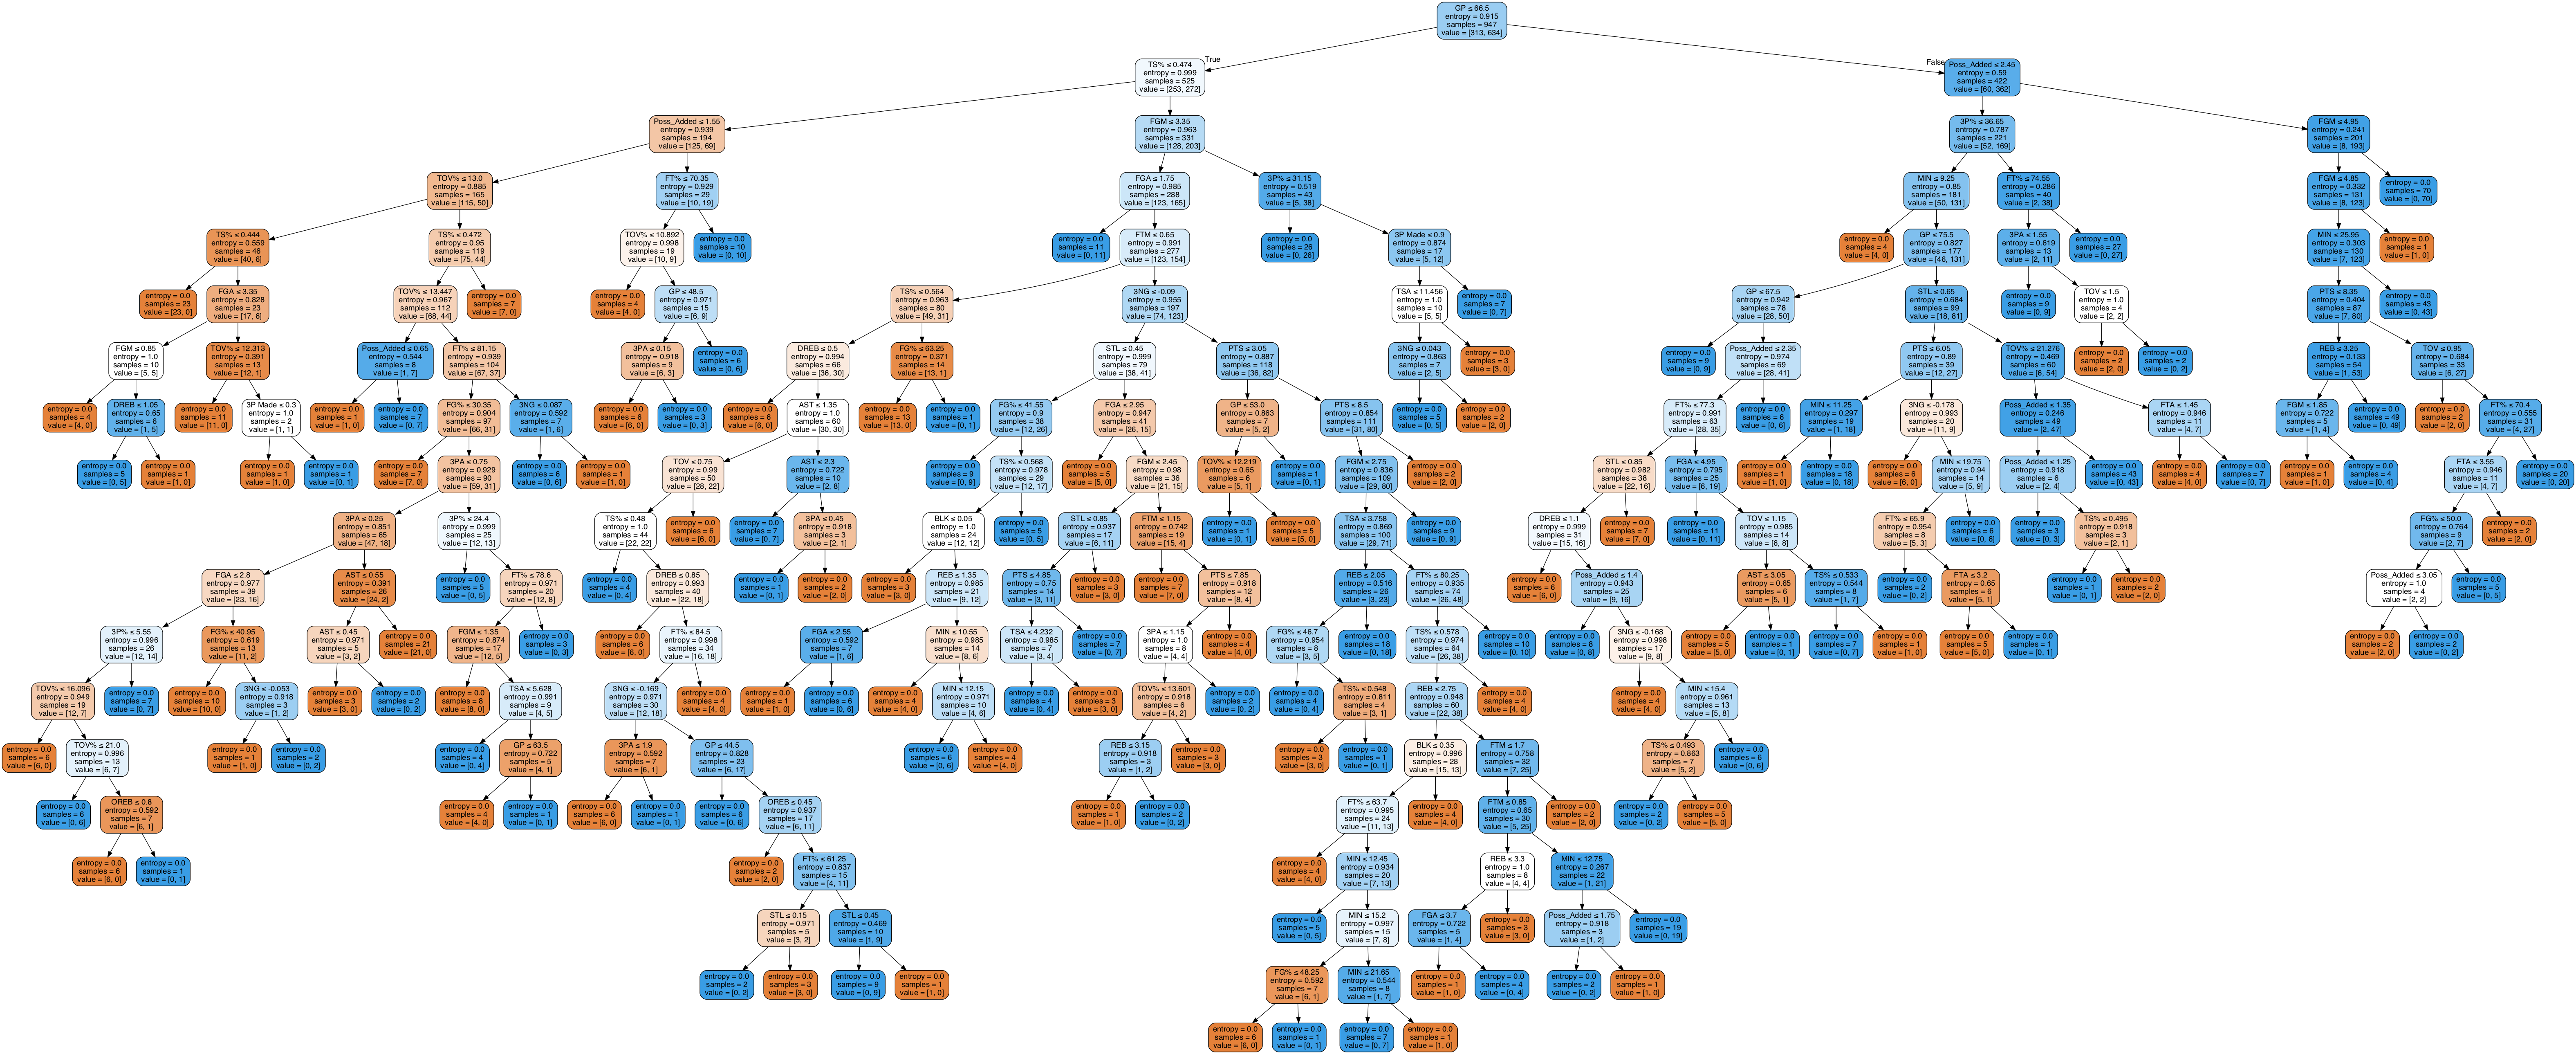

In [71]:
draw_dt(dt, feat)

In [75]:
print(dt.tree_.max_depth)
print(dt.tree_.n_features)
print(dt.tree_.node_count)

18
24
293
293


This tree is clearly overfitted to the training data and fails at classifying unseen data with the testing set.  As we observe from the vizualization, it's way too deep and the splits must be made at a very granular level to end up with this many nodes and leafs.  We'll try a gridsearch to tune the hyperparameters.  

In [76]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1,9,1),
    'min_samples_split': np.arange(2,16,2),
    'min_samples_leaf': np.arange(1,10,1),
    'max_features': np.arange(3,24,3)
}

In [77]:
dt2 = DecisionTreeClassifier()
#gridsearch(dt2, dt_param_grid, feat, target, cv=3, name='Decision Tree')


Mean Training Score: 76.52
Mean Testing Score: 72.29
Best Parameter Combination Found During Grid Search: {'criterion': 'gini', 'max_depth': 2, 'max_features': 15, 'min_samples_leaf': 3, 'min_samples_split': 8}
Total Runtime for Decision Tree GridSearch: 176.8 seconds


Accuracy for Optimal Decision Tree is 72.0
------------------------------------------------------------
Classification Report for Optimal Decision Tree Training Set:
               precision    recall  f1-score   support

         0.0       0.66      0.37      0.48       313
         1.0       0.75      0.90      0.82       634

   micro avg       0.73      0.73      0.73       947
   macro avg       0.70      0.64      0.65       947
weighted avg       0.72      0.73      0.70       947

------------------------------------------------------------
Classification Report for Optimal Decision Tree Testing Set:
               precision    recall  f1-score   support

         0.0       0.64      0.34      0.44       106
         1.0       0.73      0.90      0.81       210

   micro avg       0.72      0.72      0.72       316
   macro avg       0.69      0.62      0.63       316
weighted avg       0.70      0.72      0.69       316

--------------------------------------------------------

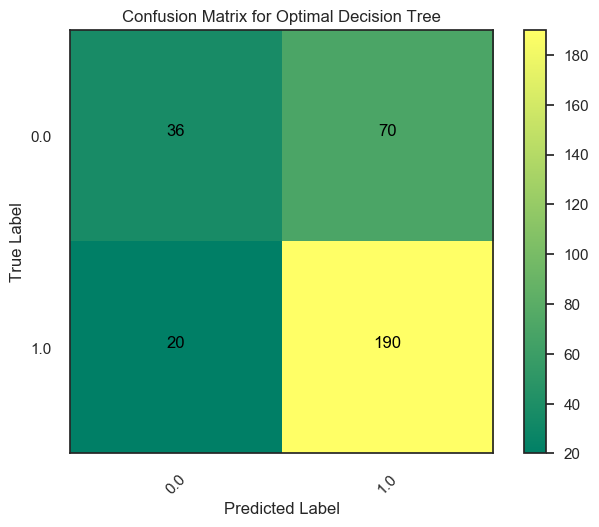

In [79]:
dt_best = DecisionTreeClassifier(criterion='gini', max_depth=2, max_features=15, min_samples_leaf=3, min_samples_split=8)
fit_predict_eval(dt_best, name='Optimal Decision Tree')

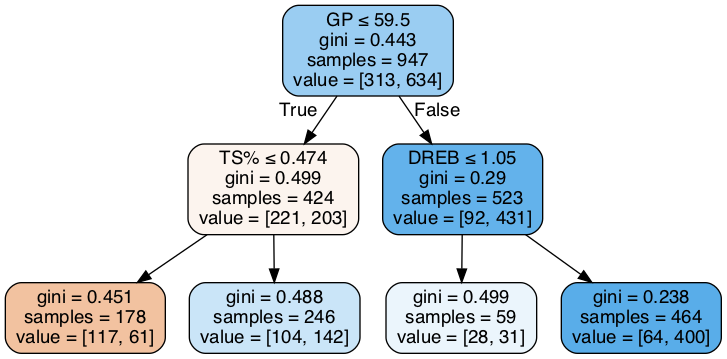

In [83]:
draw_dt(dt_best, feat)

A very simple and easily interpreted tree.  Only 3 splits, so it's simple to discern which features are the most important with this model.

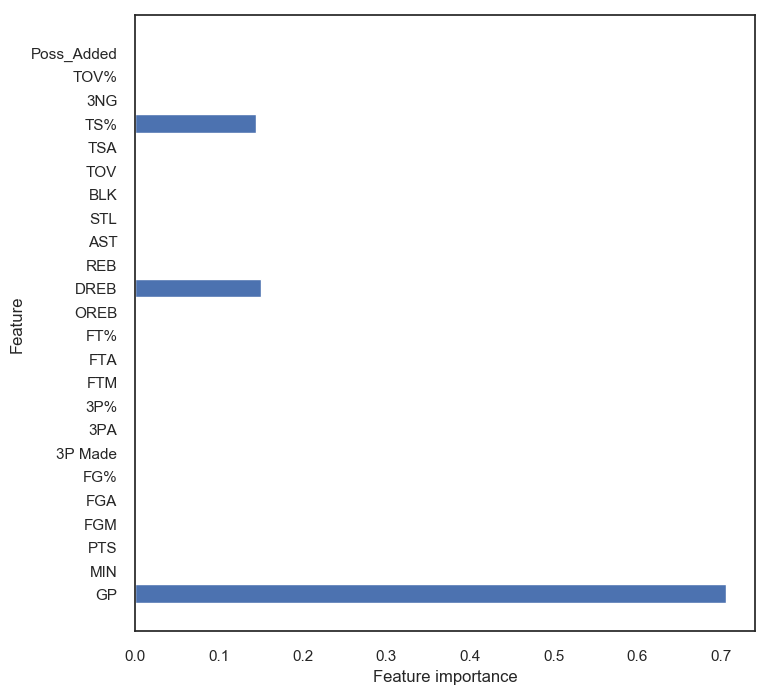

In [86]:
plot_feature_importances(dt_best)

I got a few different sets of "optimal" parameters running this gridsearch several times, so I'll compare the others and use the one with the best combination of accuracy and F1.

Accuracy for Optimal Decision Tree 2 is 73.0
------------------------------------------------------------
Classification Report for Optimal Decision Tree 2 Training Set:
               precision    recall  f1-score   support

         0.0       0.62      0.45      0.52       313
         1.0       0.76      0.86      0.81       634

   micro avg       0.73      0.73      0.73       947
   macro avg       0.69      0.66      0.67       947
weighted avg       0.72      0.73      0.72       947

------------------------------------------------------------
Classification Report for Optimal Decision Tree 2 Testing Set:
               precision    recall  f1-score   support

         0.0       0.64      0.43      0.52       106
         1.0       0.75      0.88      0.81       210

   micro avg       0.73      0.73      0.73       316
   macro avg       0.70      0.66      0.66       316
weighted avg       0.72      0.73      0.71       316

--------------------------------------------------

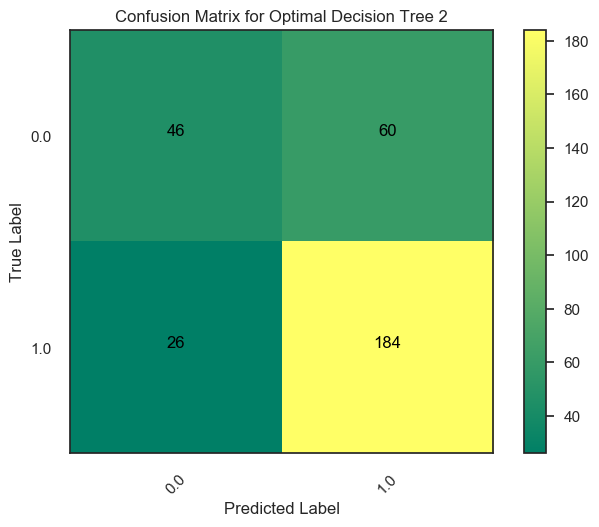

In [81]:
dt_best2 = DecisionTreeClassifier(criterion='gini', max_depth=3, max_features=5, min_samples_leaf=1, min_samples_split=6)
fit_predict_eval(dt_best2, name='Optimal Decision Tree 2')

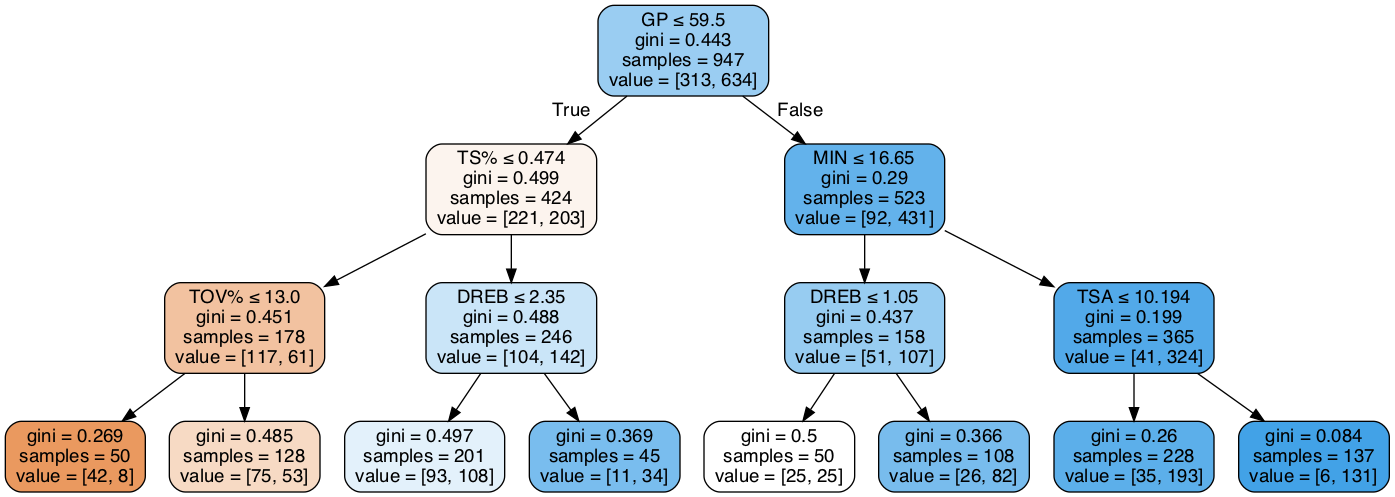

In [84]:
draw_dt(dt_best2, feat)

This one is a bit more complex but has better accuracy and F1 testing scores.

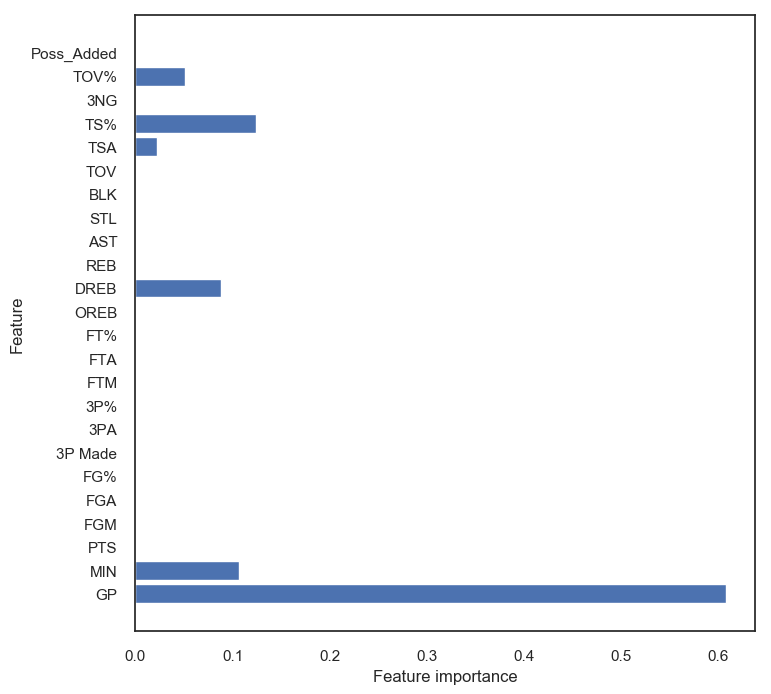

In [87]:
plot_feature_importances(dt_best2)

Accuracy for Optimal Decision Tree 3 is 73.0
------------------------------------------------------------
Classification Report for Optimal Decision Tree 3 Training Set:
               precision    recall  f1-score   support

         0.0       0.70      0.37      0.48       313
         1.0       0.75      0.92      0.82       634

   micro avg       0.74      0.74      0.74       947
   macro avg       0.72      0.64      0.65       947
weighted avg       0.73      0.74      0.71       947

------------------------------------------------------------
Classification Report for Optimal Decision Tree 3 Testing Set:
               precision    recall  f1-score   support

         0.0       0.69      0.34      0.46       106
         1.0       0.73      0.92      0.82       210

   micro avg       0.73      0.73      0.73       316
   macro avg       0.71      0.63      0.64       316
weighted avg       0.72      0.73      0.70       316

--------------------------------------------------

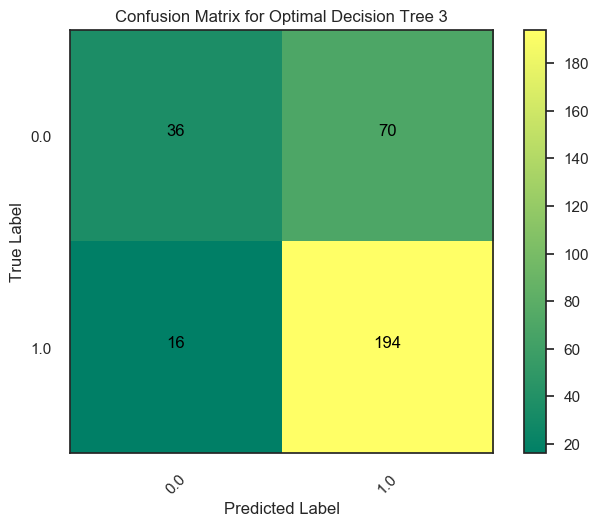

In [82]:
dt_best3 = DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=15, min_samples_leaf=9, min_samples_split=14)
fit_predict_eval(dt_best3, name= 'Optimal Decision Tree 3')

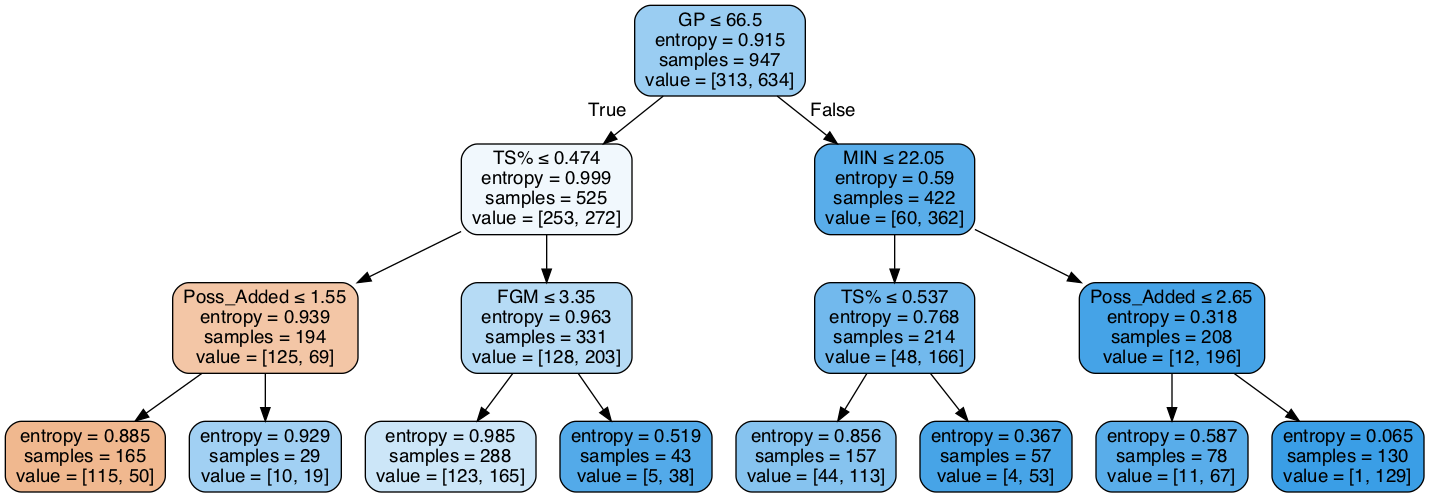

In [85]:
draw_dt(dt_best3, feat)

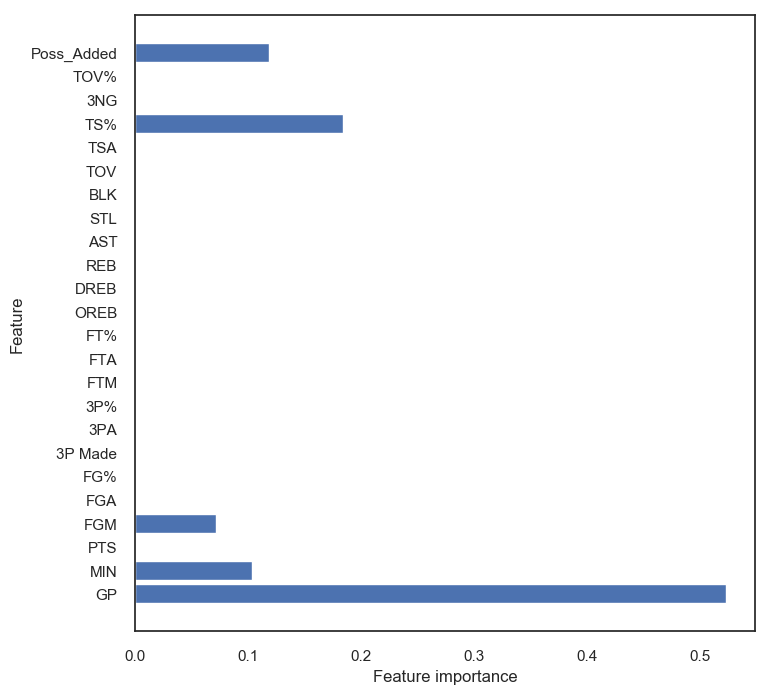

In [88]:
plot_feature_importances(dt_best3)

Comparable results, and all 3 trees place heavy weight on GP, with MIN and TS% as important secondary features.  Pretty impressive results from the trees, with **dt_best2** having the slight edge on the others. We can likely keep tuning decision trees and improve around the margins, but using an ensemble method like Random Forest will likely be a better bet.

# Random Forest

In [90]:
rf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf, feat, target, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))

Mean Cross Validation Score for Random Forest Classifier: 68.81%


Accuracy for Random Forest OOTB is 67.0
------------------------------------------------------------
Classification Report for Random Forest OOTB Training Set:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       313
         1.0       0.99      0.99      0.99       634

   micro avg       0.98      0.98      0.98       947
   macro avg       0.98      0.98      0.98       947
weighted avg       0.98      0.98      0.98       947

------------------------------------------------------------
Classification Report for Random Forest OOTB Testing Set:
               precision    recall  f1-score   support

         0.0       0.51      0.47      0.49       106
         1.0       0.74      0.77      0.75       210

   micro avg       0.67      0.67      0.67       316
   macro avg       0.62      0.62      0.62       316
weighted avg       0.66      0.67      0.66       316

------------------------------------------------------------


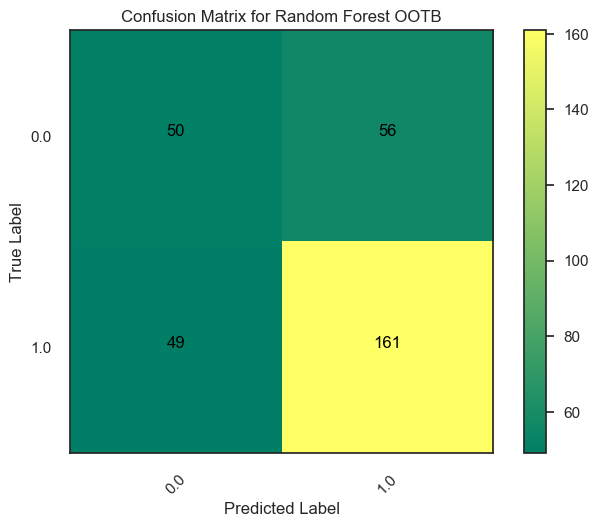

In [91]:
fit_predict_eval(rf, name='Random Forest OOTB')

Extremely overfitted like our first decision tree...let's again run a gridsearch and tune our hyperparameters.

In [92]:
rf_param_grid = {
    'n_estimators': np.arange(10,100,10),
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2,8,1),
    'min_samples_split': np.arange(2,10,1),
    'min_samples_leaf': np.arange(1,9,2)
}

In [93]:
#gridsearch(rf,rf_param_grid, feat, target, name='Random Forest')

Mean Training Score: 79.51
Mean Testing Score: 74.74
Best Parameter Combination Found During Grid Search: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 10}
Total Runtime for Random Forest GridSearch: 1.011e+03 seconds


In [130]:
rf_best = RandomForestClassifier(criterion= 'gini', max_depth=3 , min_samples_leaf=3 , min_samples_split=6 , n_estimators=10 )

Accuracy for Optimal Random Forest is 75.0
------------------------------------------------------------
Classification Report for Optimal Random Forest Training Set:
               precision    recall  f1-score   support

         0.0       0.65      0.55      0.60       313
         1.0       0.79      0.85      0.82       634

   micro avg       0.75      0.75      0.75       947
   macro avg       0.72      0.70      0.71       947
weighted avg       0.75      0.75      0.75       947

------------------------------------------------------------
Classification Report for Optimal Random Forest Testing Set:
               precision    recall  f1-score   support

         0.0       0.66      0.54      0.59       106
         1.0       0.79      0.86      0.82       210

   micro avg       0.75      0.75      0.75       316
   macro avg       0.72      0.70      0.71       316
weighted avg       0.74      0.75      0.74       316

--------------------------------------------------------

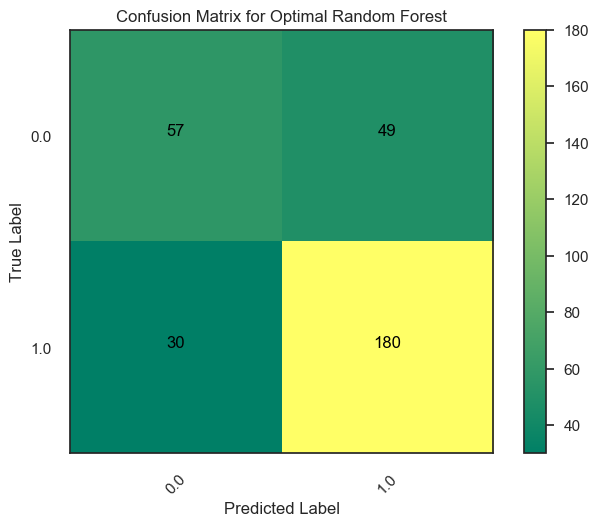

In [132]:
fit_predict_eval(rf_best, name = 'Optimal Random Forest')

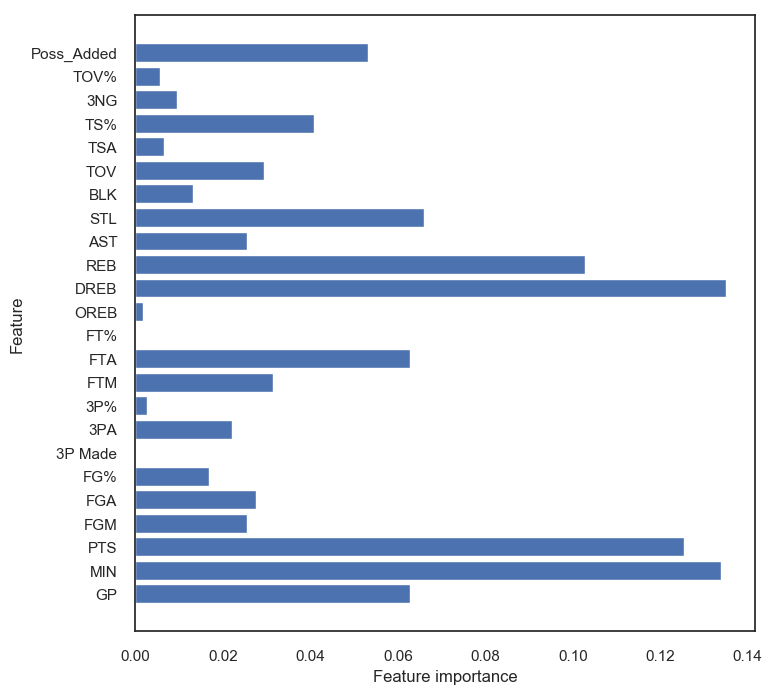

In [133]:
plot_feature_importances(rf_best)

In [138]:
rf_best2 = RandomForestClassifier(criterion= 'gini', max_depth= 7, min_samples_leaf= 1, min_samples_split= 9, n_estimators= 20)

Accuracy for None is 73.0
------------------------------------------------------------
Classification Report for None Training Set:
               precision    recall  f1-score   support

         0.0       0.84      0.74      0.79       313
         1.0       0.88      0.93      0.90       634

   micro avg       0.87      0.87      0.87       947
   macro avg       0.86      0.83      0.84       947
weighted avg       0.87      0.87      0.86       947

------------------------------------------------------------
Classification Report for None Testing Set:
               precision    recall  f1-score   support

         0.0       0.63      0.47      0.54       106
         1.0       0.76      0.86      0.81       210

   micro avg       0.73      0.73      0.73       316
   macro avg       0.70      0.67      0.68       316
weighted avg       0.72      0.73      0.72       316

------------------------------------------------------------


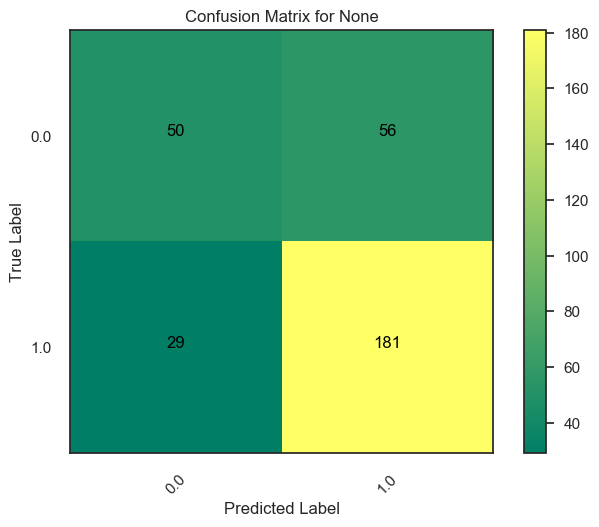

In [139]:
fit_predict_eval(rf_best2)

We can see that Random Forest is utilizing a lot more features than our single optimized decision trees, and performing slightly better as expected.  **rf_best** was the highest performing, with accuracy of 75% and an F1 score of 74%.

# Gradient Boosted Trees

In [107]:
gbt_clf = GradientBoostingClassifier()

Accuracy for GBT OOTB is 72.0
------------------------------------------------------------
Classification Report for GBT OOTB Training Set:
               precision    recall  f1-score   support

         0.0       0.90      0.77      0.83       313
         1.0       0.89      0.96      0.92       634

   micro avg       0.90      0.90      0.90       947
   macro avg       0.90      0.86      0.88       947
weighted avg       0.90      0.90      0.89       947

------------------------------------------------------------
Classification Report for GBT OOTB Testing Set:
               precision    recall  f1-score   support

         0.0       0.63      0.44      0.52       106
         1.0       0.76      0.87      0.81       210

   micro avg       0.72      0.72      0.72       316
   macro avg       0.69      0.66      0.66       316
weighted avg       0.71      0.72      0.71       316

------------------------------------------------------------


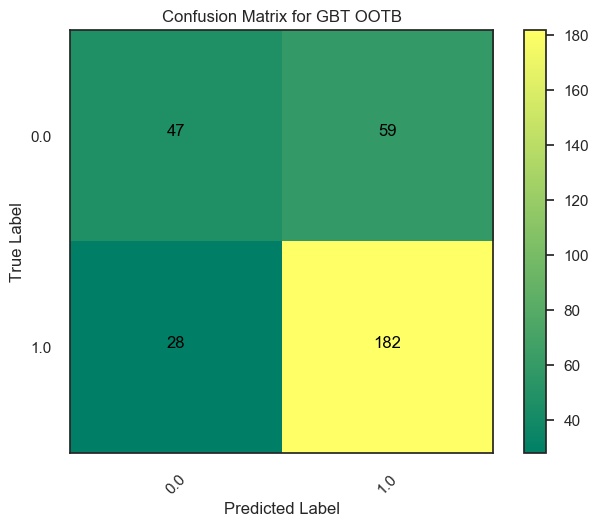

In [108]:
fit_predict_eval(gbt_clf, name = 'GBT OOTB')

In [169]:
gbt_param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09],
    'n_estimators': [50, 100, 200, 250],
    'max_depth': [3, 5, 7, 9],
    'max_features': np.arange(3,24,3),
    'subsample': [0.5, 0.8, 1.0]
}

In [170]:
gridsearch(gbt_clf, gbt_param_grid, feat, target, name='GBT GS')

Mean Training Score: 94.28
Mean Testing Score: 79.02
Best Parameter Combination Found During Grid Search: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 21, 'n_estimators': 250, 'subsample': 0.5}
Total Runtime for GBT GS GridSearch: 7.041e+03 seconds


Accuracy for Optimal Gradient Booster is 74.0
------------------------------------------------------------
Classification Report for Optimal Gradient Booster Training Set:
               precision    recall  f1-score   support

         0.0       0.79      0.59      0.68       313
         1.0       0.82      0.92      0.87       634

   micro avg       0.81      0.81      0.81       947
   macro avg       0.81      0.76      0.77       947
weighted avg       0.81      0.81      0.81       947

------------------------------------------------------------
Classification Report for Optimal Gradient Booster Testing Set:
               precision    recall  f1-score   support

         0.0       0.68      0.44      0.54       106
         1.0       0.76      0.90      0.82       210

   micro avg       0.74      0.74      0.74       316
   macro avg       0.72      0.67      0.68       316
weighted avg       0.73      0.74      0.73       316

-----------------------------------------------

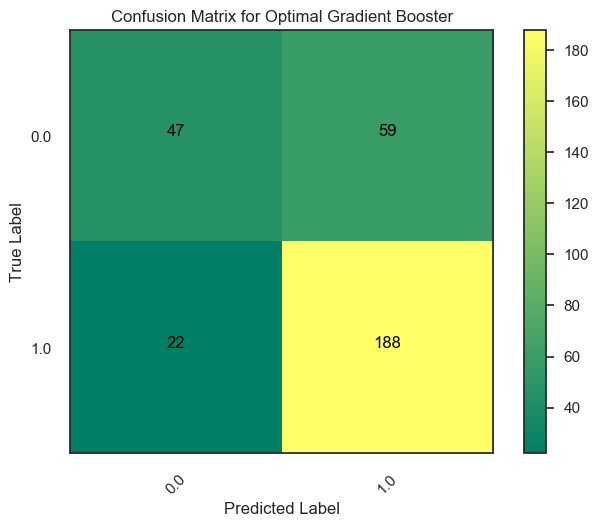

In [172]:
gbt_best = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=21, n_estimators=250, subsample=0.5)
fit_predict_eval(gbt_best, name = 'Optimal Gradient Booster')

I sincerely regret running the gridsearch for this one, clocking in at about 117 minutes.  Performance is good though, about on par with Random Forest.  Let's move on to our final attempt with XGBoost.

# XGBoost

In [112]:
import xgboost as xgb
from xgboost import XGBClassifier

In [113]:
xgb_clf = xgb.XGBClassifier()

Accuracy for XGB OOTB is 73.0
------------------------------------------------------------
Classification Report for XGB OOTB Training Set:
               precision    recall  f1-score   support

         0.0       0.87      0.76      0.81       313
         1.0       0.89      0.94      0.91       634

   micro avg       0.88      0.88      0.88       947
   macro avg       0.88      0.85      0.86       947
weighted avg       0.88      0.88      0.88       947

------------------------------------------------------------
Classification Report for XGB OOTB Testing Set:
               precision    recall  f1-score   support

         0.0       0.62      0.52      0.57       106
         1.0       0.78      0.84      0.81       210

   micro avg       0.73      0.73      0.73       316
   macro avg       0.70      0.68      0.69       316
weighted avg       0.73      0.73      0.73       316

------------------------------------------------------------


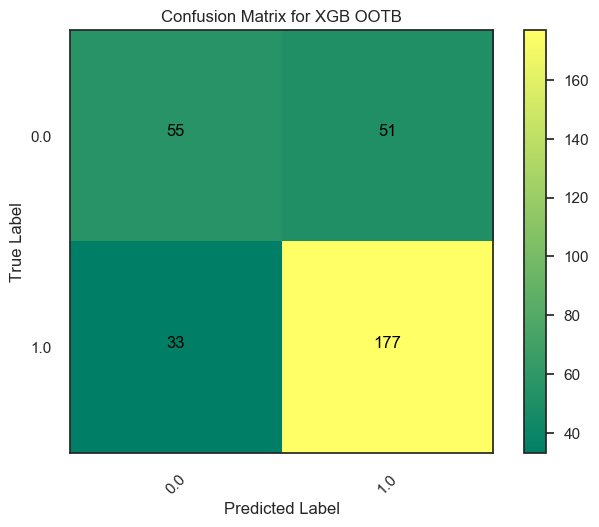

In [114]:
fit_predict_eval(xgb_clf, name = 'XGB OOTB')

In [115]:
xgb_param_grid = {
    "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': [1,2,3,4,6,8],
    'min_child_weight': [1,5,10,20],
    'subsample': [0.1,0.3,0.7,0.9],
    'n_estimators': [100,250,500],
}

In [116]:
#gridsearch(xgb_clf, xgb_param_grid, feat, target, name = 'XGBoost')

Mean Training Score: 79.55
Mean Testing Score: 74.27
Best Parameter Combination Found During Grid Search: {'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 250, 'subsample': 0.1}
Total Runtime for XGBoost GridSearch: 1.28e+03 seconds


In [117]:
xgb_best1 = xgb.XGBClassifier(learning_rate=0.001, max_depth=3, min_child_weight=5, n_estimators=250, subsample=0.1)

Accuracy for None is 74.0
------------------------------------------------------------
Classification Report for None Training Set:
               precision    recall  f1-score   support

         0.0       0.63      0.53      0.58       313
         1.0       0.79      0.85      0.82       634

   micro avg       0.74      0.74      0.74       947
   macro avg       0.71      0.69      0.70       947
weighted avg       0.74      0.74      0.74       947

------------------------------------------------------------
Classification Report for None Testing Set:
               precision    recall  f1-score   support

         0.0       0.65      0.52      0.58       106
         1.0       0.78      0.86      0.82       210

   micro avg       0.74      0.74      0.74       316
   macro avg       0.71      0.69      0.70       316
weighted avg       0.73      0.74      0.74       316

------------------------------------------------------------


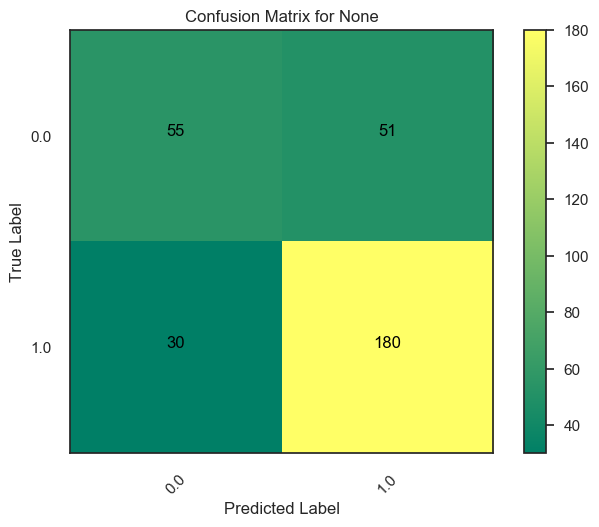

In [118]:
fit_predict_eval(xgb_best1)

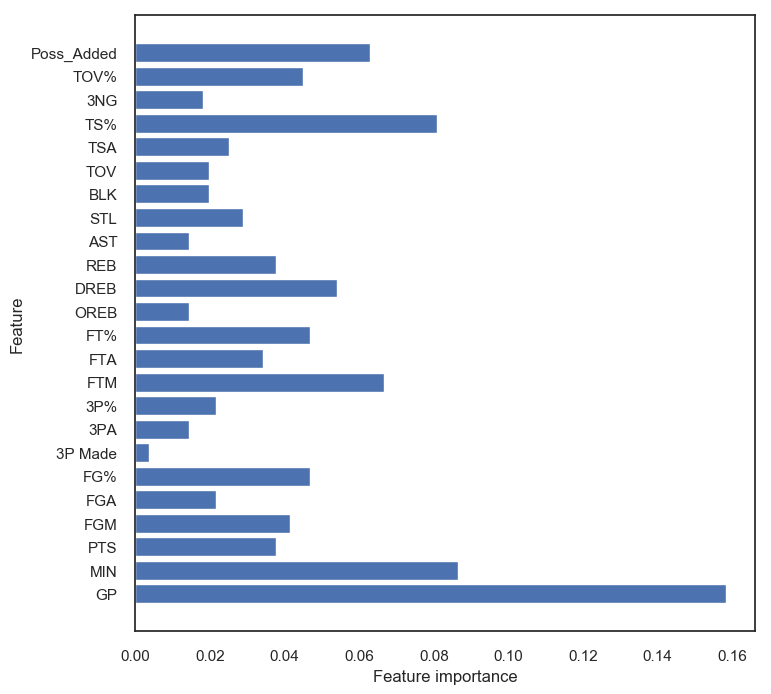

In [119]:
plot_feature_importances(xgb_best1)

Again I had varying results from several gridsearch runs, so I'll plug in other "optimal" parameters and see which one scores best.

In [120]:
xgb_best2 = xgb.XGBClassifier(learning_rate=0.005, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.1)
xgb_best3 = xgb.XGBClassifier(learning_rate=0.0001, max_depth=3, min_child_weight=5, n_estimators=250, subsample=0.1)

Accuracy for None is 75.0
------------------------------------------------------------
Classification Report for None Training Set:
               precision    recall  f1-score   support

         0.0       0.63      0.54      0.58       313
         1.0       0.79      0.85      0.82       634

   micro avg       0.74      0.74      0.74       947
   macro avg       0.71      0.69      0.70       947
weighted avg       0.74      0.74      0.74       947

------------------------------------------------------------
Classification Report for None Testing Set:
               precision    recall  f1-score   support

         0.0       0.64      0.57      0.60       106
         1.0       0.79      0.84      0.81       210

   micro avg       0.75      0.75      0.75       316
   macro avg       0.72      0.70      0.71       316
weighted avg       0.74      0.75      0.74       316

------------------------------------------------------------


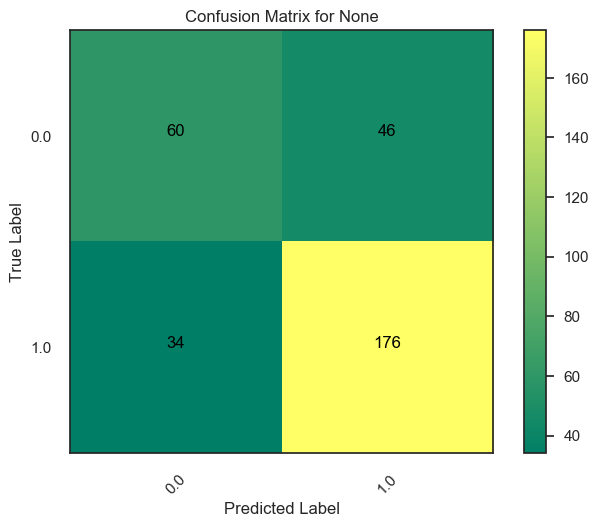

In [121]:
fit_predict_eval(xgb_best2)

Accuracy for None is 74.0
------------------------------------------------------------
Classification Report for None Training Set:
               precision    recall  f1-score   support

         0.0       0.64      0.53      0.58       313
         1.0       0.78      0.85      0.82       634

   micro avg       0.74      0.74      0.74       947
   macro avg       0.71      0.69      0.70       947
weighted avg       0.74      0.74      0.74       947

------------------------------------------------------------
Classification Report for None Testing Set:
               precision    recall  f1-score   support

         0.0       0.65      0.52      0.58       106
         1.0       0.78      0.86      0.82       210

   micro avg       0.74      0.74      0.74       316
   macro avg       0.71      0.69      0.70       316
weighted avg       0.73      0.74      0.74       316

------------------------------------------------------------


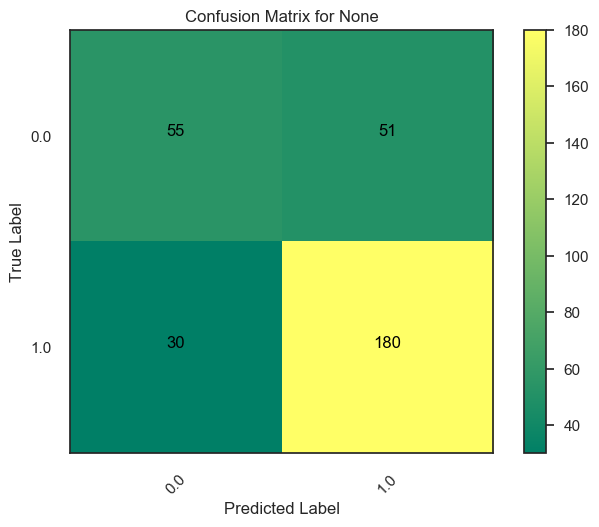

In [122]:
fit_predict_eval(xgb_best3)

# Conclusions

XGBoost clearly seems to be the winner here, but it was certainly computationally expensive to run a gridsearch (although we could've used fewer values for each parameter to reduce that time).  
<br>
Random Forest and even simple decision trees performed well also...depending on the ultimate application of this model, we may decide to choose any of those.  
<br>
For our purposes, we'll go with the theme of being GREEDY and take the absolute best metrics, which belong to our 'xgb_best2' classifier, with a 75% accuracy score, 74% precision, 75% recall, and 74% F1.
<br>

As a final test, let's use the model to make some predictions on those 2015 players that we kept in the "new_df" but removed from our training/testing sets.  The jury is still officially out on these guys but the 2019-2020 season would mark their 5th, so we have a pretty good idea at this point who will make it and who won't.

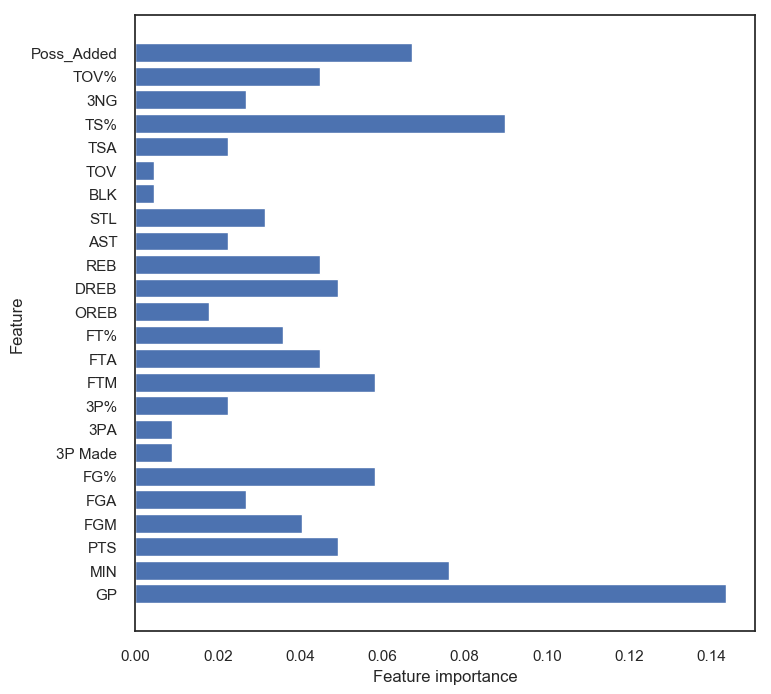

In [140]:
plot_feature_importances(xgb_best2)

In [142]:
new_df.set_index('Name', inplace=True)
new_df.drop('TARGET_5Yrs', axis=1, inplace=True)

In [160]:
new_df.reset_index(inplace=True)

In [161]:
new_df.head()

Name  GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  \
0  JaKarr Sampson  74  15.3  5.2  2.0  4.7  42.2      0.4  1.7  24.4   
1     Malik Sealy  58  11.6  5.7  2.3  5.5  42.6      0.1  0.5  22.6   
2     Matt Geiger  48  11.5  4.5  1.6  3.0  52.4      0.0  0.1   0.0   
3    Tony Bennett  75  11.4  3.7  1.5  3.5  42.3      0.3  1.1  32.5   
4     Don MacLean  62  10.9  6.6  2.5  5.8  43.5      0.0  0.1  50.0   

      ...      REB  AST  STL  BLK  TOV    TSA       TS%    3NG       TOV%  \
0     ...      2.2  1.0  0.5  0.3  1.0  5.272  0.493171 -0.602  15.943878   
1     ...      1.9  0.8  0.6  0.1  1.0  6.072  0.469368 -0.230  14.140271   
2     ...      2.5  0.3  0.3  0.4  0.8  3.836  0.586548 -0.106  17.256255   
3     ...      0.8  1.8  0.4  0.0  0.7  3.720  0.497312 -0.266  15.837104   
4     ...      2.0  0.6  0.2  0.1  0.7  6.592  0.500607 -0.106   9.599561   

   Poss_Added  
0         1.3  
1         1.7  
2         1.7  
3         0.6  
4         0.8  

[5 rows x 25 columns]

In [162]:
xgb_preds = []

for p in unk_2015:
    new_p =  new_df[new_df['Name'] == p]
    new_p.drop('Name', inplace=True, axis=1)
    pred = xgb_best2.predict(new_p)
    xgb_preds.append(pred)

In [163]:
len(xgb_preds)

26

In [164]:
my_preds = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
len(my_preds)

26

In [165]:
xgb_results = pd.DataFrame({'2015 Player Name': unk_2015, 'Model Predictions': xgb_preds, 'Human Prediction': my_preds})

In [166]:
xgb_results

2015 Player Name Model Predictions  Human Prediction
0           Justise Winslow             [1.0]                 1
1          D'Angelo Russell             [1.0]                 1
2              Devin Booker             [1.0]                 1
3           Stanley Johnson             [1.0]                 1
4              Myles Turner             [1.0]                 1
5       Willie Cauley-Stein             [1.0]                 1
6           Josh Richardson             [1.0]                 1
7   Rondae Hollis-Jefferson             [1.0]                 1
8            Frank Kaminsky             [1.0]                 1
9             Anthony Brown             [0.0]                 0
10          Larry Nance Jr.             [1.0]                 1
11             Bobby Portis             [1.0]                 1
12             Jerian Grant             [1.0]                 1
13               Tyus Jones             [0.0]                 1
14         Chris McCullough             [1.0]                 0
15            Norman Powell             [1.0]                 1
16         Jonathon Simmons             [1.0]                 1
17            Rashad Vaughn             [0.0]                 0
18            Jarell Martin             [1.0]                 1
19           Richaun Holmes             [1.0]                 1
20            Cameron Payne             [1.0]                 1
21          Justin Anderson             [1.0]                 1
22          Lamar Patterson             [0.0]                 0
23              Willie Reed             [1.0]                 0
24          Darrun Hilliard             [0.0]                 0
25            Adreian Payne             [1.0]                 0

Not perfect, but we match 22/26, so almost 85% accuracy!  Again there aren't "true" labels for these players yet, but I'm fairly confident in my own predictions after seeing 4 years of the player data.

## Future Work
 - Scrub the data even more thoroughly to ensure accuracy
 - Consider additional feature engineering - there are a lot of advanced metrics that can apply to NBA.
 - Correct all the 2016 player data
 - Scrape for college statistics and concatenate that data for the same player sample
 - Create a new test set with samples of  rookie year stats from (GTown, UNC, Duke, etc.) or HOFers